First we import everything include the dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import plotly
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import gc

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
POS_CASH_balance = pd.read_csv("home-credit-default-risk/POS_CASH_balance.csv")
Application_test = pd.read_csv("home-credit-default-risk/application_test.csv")
Application_train = pd.read_csv("home-credit-default-risk/application_train.csv")
Bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
Bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")
Credit_card_balance = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")
Installments_payments = pd.read_csv("home-credit-default-risk/installments_payments.csv")
Previous_application = pd.read_csv("home-credit-default-risk/previous_application.csv")
Sample_submission = pd.read_csv("home-credit-default-risk/sample_submission.csv")

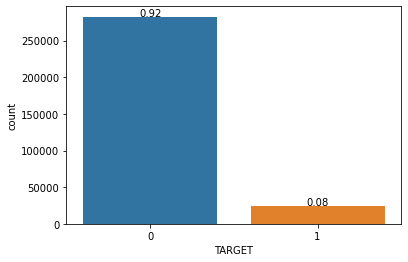

In [3]:
ax = sns.countplot(x="TARGET",data=Application_train)
total = float(Application_train.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height+500,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
plt.show()

<h3>Our target variable is imbalance with 0 = 0.92 and 1 = 0.08

First we will feature engineer and dealing with Application Train and Test First

We want to fill missing categorical data by basically fill most frequent values in data

In [4]:
missing_categorical_data_train = Application_train.iloc[:,Application_train.isnull().sum().values>0].select_dtypes("object")
missing_categorical_data_test = Application_test.iloc[:,Application_test.isnull().sum().values>0].select_dtypes("object")


In [5]:
missing_categorical_data_train

NAME_TYPE_SUITE OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0        Unaccompanied        Laborers   reg oper account  block of flats   
1               Family      Core staff   reg oper account  block of flats   
2        Unaccompanied        Laborers                NaN             NaN   
3        Unaccompanied        Laborers                NaN             NaN   
4        Unaccompanied      Core staff                NaN             NaN   
...                ...             ...                ...             ...   
307506   Unaccompanied     Sales staff   reg oper account  block of flats   
307507   Unaccompanied             NaN   reg oper account  block of flats   
307508   Unaccompanied        Managers   reg oper account  block of flats   
307509   Unaccompanied        Laborers                NaN  block of flats   
307510   Unaccompanied        Laborers                NaN  block of flats   

       WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0            Stone, brick                  No  
1                   Block                  No  
2                     NaN                 NaN  
3                     NaN                 NaN  
4                     NaN                 NaN  
...                   ...                 ...  
307506       Stone, brick                  No  
307507       Stone, brick                  No  
307508              Panel                  No  
307509       Stone, brick                  No  
307510              Panel                  No  

[307511 rows x 6 columns]

In [6]:
missing_categorical_data_test

NAME_TYPE_SUITE     OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0       Unaccompanied                 NaN                NaN  block of flats   
1       Unaccompanied  Low-skill Laborers                NaN             NaN   
2                 NaN             Drivers                NaN             NaN   
3       Unaccompanied         Sales staff   reg oper account  block of flats   
4       Unaccompanied                 NaN                NaN             NaN   
...               ...                 ...                ...             ...   
48739   Unaccompanied                 NaN                NaN             NaN   
48740   Unaccompanied         Sales staff                NaN             NaN   
48741   Unaccompanied                 NaN                NaN  block of flats   
48742          Family            Managers                NaN  block of flats   
48743   Unaccompanied          Core staff                NaN             NaN   

      WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0           Stone, brick                  No  
1                    NaN                 NaN  
2                    NaN                 NaN  
3                  Panel                  No  
4                    NaN                 NaN  
...                  ...                 ...  
48739                NaN                 NaN  
48740                NaN                 NaN  
48741       Stone, brick                  No  
48742              Panel                  No  
48743                NaN                 NaN  

[48744 rows x 6 columns]

In [7]:
Want_to_fill_train = Application_train.iloc[:,Application_train.isnull().sum().values > 0].select_dtypes("object")
Want_to_fill_test = Application_test.iloc[:,Application_test.isnull().sum().values >0].select_dtypes("object")

In [8]:
Want_to_fill_train

NAME_TYPE_SUITE OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0        Unaccompanied        Laborers   reg oper account  block of flats   
1               Family      Core staff   reg oper account  block of flats   
2        Unaccompanied        Laborers                NaN             NaN   
3        Unaccompanied        Laborers                NaN             NaN   
4        Unaccompanied      Core staff                NaN             NaN   
...                ...             ...                ...             ...   
307506   Unaccompanied     Sales staff   reg oper account  block of flats   
307507   Unaccompanied             NaN   reg oper account  block of flats   
307508   Unaccompanied        Managers   reg oper account  block of flats   
307509   Unaccompanied        Laborers                NaN  block of flats   
307510   Unaccompanied        Laborers                NaN  block of flats   

       WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0            Stone, brick                  No  
1                   Block                  No  
2                     NaN                 NaN  
3                     NaN                 NaN  
4                     NaN                 NaN  
...                   ...                 ...  
307506       Stone, brick                  No  
307507       Stone, brick                  No  
307508              Panel                  No  
307509       Stone, brick                  No  
307510              Panel                  No  

[307511 rows x 6 columns]

In [9]:
Want_to_fill_test

NAME_TYPE_SUITE     OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0       Unaccompanied                 NaN                NaN  block of flats   
1       Unaccompanied  Low-skill Laborers                NaN             NaN   
2                 NaN             Drivers                NaN             NaN   
3       Unaccompanied         Sales staff   reg oper account  block of flats   
4       Unaccompanied                 NaN                NaN             NaN   
...               ...                 ...                ...             ...   
48739   Unaccompanied                 NaN                NaN             NaN   
48740   Unaccompanied         Sales staff                NaN             NaN   
48741   Unaccompanied                 NaN                NaN  block of flats   
48742          Family            Managers                NaN  block of flats   
48743   Unaccompanied          Core staff                NaN             NaN   

      WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0           Stone, brick                  No  
1                    NaN                 NaN  
2                    NaN                 NaN  
3                  Panel                  No  
4                    NaN                 NaN  
...                  ...                 ...  
48739                NaN                 NaN  
48740                NaN                 NaN  
48741       Stone, brick                  No  
48742              Panel                  No  
48743                NaN                 NaN  

[48744 rows x 6 columns]

Visualization null categorical data. with target

In [10]:
Want_to_fill_train["TARGET"] = Application_train["TARGET"]
Want_to_fill_train

NAME_TYPE_SUITE OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0        Unaccompanied        Laborers   reg oper account  block of flats   
1               Family      Core staff   reg oper account  block of flats   
2        Unaccompanied        Laborers                NaN             NaN   
3        Unaccompanied        Laborers                NaN             NaN   
4        Unaccompanied      Core staff                NaN             NaN   
...                ...             ...                ...             ...   
307506   Unaccompanied     Sales staff   reg oper account  block of flats   
307507   Unaccompanied             NaN   reg oper account  block of flats   
307508   Unaccompanied        Managers   reg oper account  block of flats   
307509   Unaccompanied        Laborers                NaN  block of flats   
307510   Unaccompanied        Laborers                NaN  block of flats   

       WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  TARGET  
0            Stone, brick                  No       1  
1                   Block                  No       0  
2                     NaN                 NaN       0  
3                     NaN                 NaN       0  
4                     NaN                 NaN       0  
...                   ...                 ...     ...  
307506       Stone, brick                  No       0  
307507       Stone, brick                  No       0  
307508              Panel                  No       0  
307509       Stone, brick                  No       1  
307510              Panel                  No       0  

[307511 rows x 7 columns]

In [11]:
viz_data = Application_train.iloc[:,Application_train.isnull().sum().values >0]
viz_data2 = Application_test.iloc[:,Application_test.isnull().sum().values>0]
Percentage_missing_train = viz_data.isnull().sum()/Want_to_fill_train.shape[0]*100
Percentage_missing_test = viz_data2.isnull().sum()/Want_to_fill_train.shape[0]*100
Percentage_missing_train = pd.DataFrame(Percentage_missing_train,columns=["Percentage_Missing_Values"])
Percentage_missing_test = pd.DataFrame(Percentage_missing_test,columns=["Percentage_Missing_Values"])
Percentage_missing_train.sort_values(by="Percentage_Missing_Values",ascending=False,inplace=True)
Percentage_missing_test.sort_values(by="Percentage_Missing_Values",ascending=False,inplace=True)
Percentage_missing_train["Columns_Name"] = Percentage_missing_train.index
Percentage_missing_test["Columns_Name"] = Percentage_missing_test.index

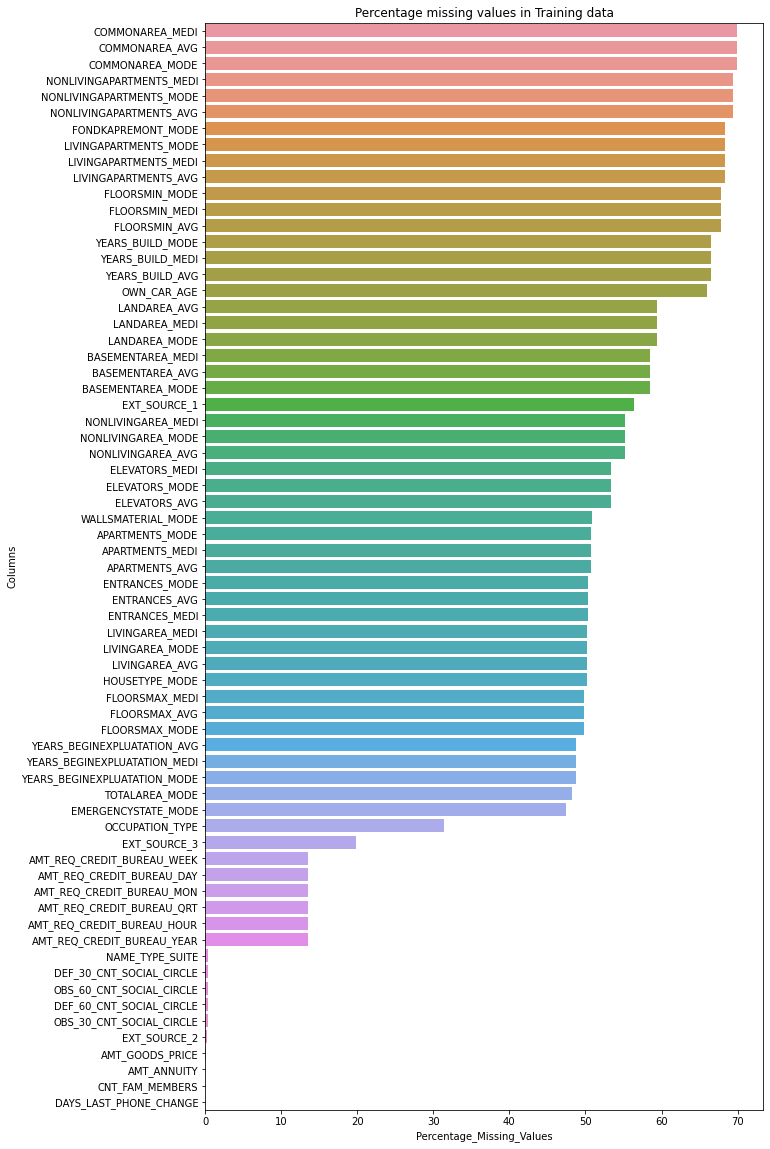

In [12]:
plt.figure(figsize=(10,20))
sns.barplot(y="Columns_Name",x="Percentage_Missing_Values",data = Percentage_missing_train)
plt.ylabel("Columns")
plt.title("Percentage missing values in Training data")
plt.show()

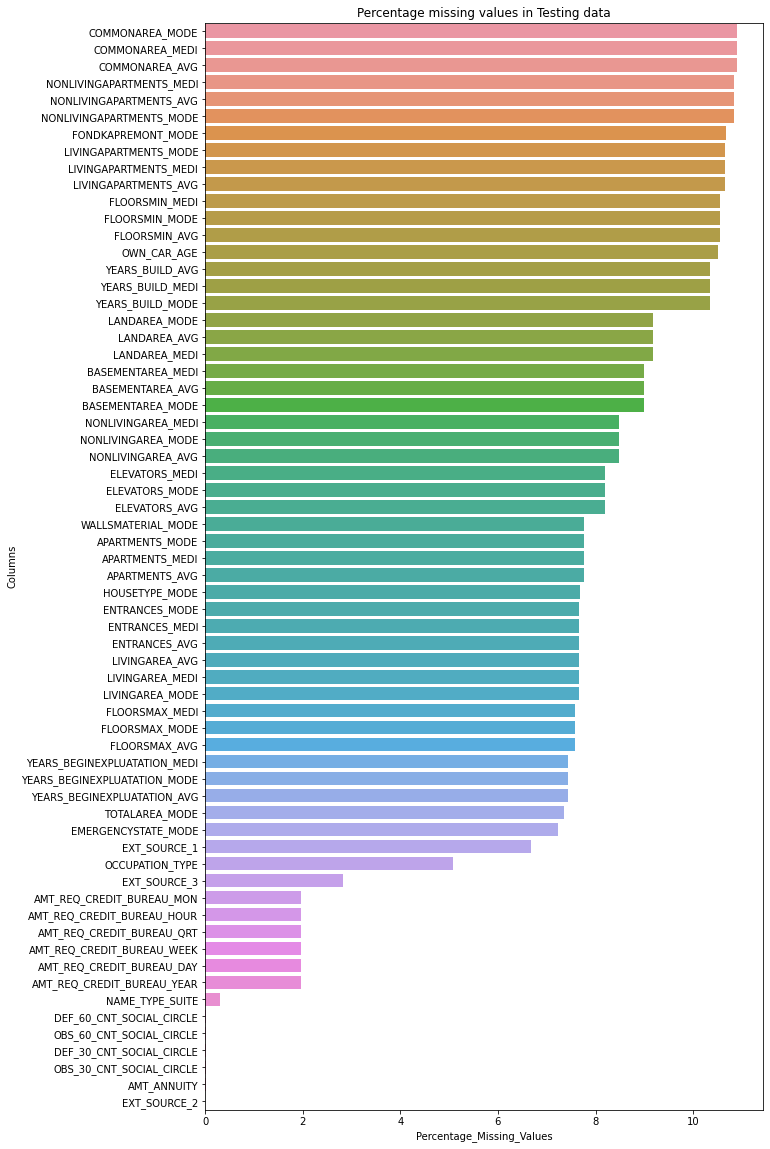

In [13]:
plt.figure(figsize=(10,20))
sns.barplot(y="Columns_Name",x="Percentage_Missing_Values",data = Percentage_missing_test)
plt.ylabel("Columns")
plt.title("Percentage missing values in Testing data")
plt.show()

<h4>We saw that percentage missing values in test data isn't much compared with percentage missing values in train data. So we shouldn't drop any columns in Application train and Application test because in the test data have only a few missing values.

We will deal with missing categorical value first.

In [14]:
missing_categorical_data_train["TARGET"] = Application_train["TARGET"]
missing_categorical_data_train

NAME_TYPE_SUITE OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0        Unaccompanied        Laborers   reg oper account  block of flats   
1               Family      Core staff   reg oper account  block of flats   
2        Unaccompanied        Laborers                NaN             NaN   
3        Unaccompanied        Laborers                NaN             NaN   
4        Unaccompanied      Core staff                NaN             NaN   
...                ...             ...                ...             ...   
307506   Unaccompanied     Sales staff   reg oper account  block of flats   
307507   Unaccompanied             NaN   reg oper account  block of flats   
307508   Unaccompanied        Managers   reg oper account  block of flats   
307509   Unaccompanied        Laborers                NaN  block of flats   
307510   Unaccompanied        Laborers                NaN  block of flats   

       WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  TARGET  
0            Stone, brick                  No       1  
1                   Block                  No       0  
2                     NaN                 NaN       0  
3                     NaN                 NaN       0  
4                     NaN                 NaN       0  
...                   ...                 ...     ...  
307506       Stone, brick                  No       0  
307507       Stone, brick                  No       0  
307508              Panel                  No       0  
307509       Stone, brick                  No       1  
307510              Panel                  No       0  

[307511 rows x 7 columns]

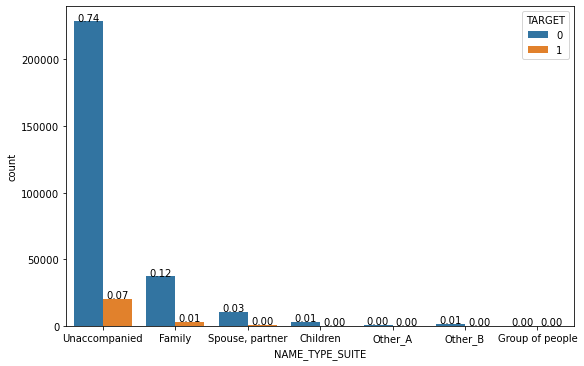

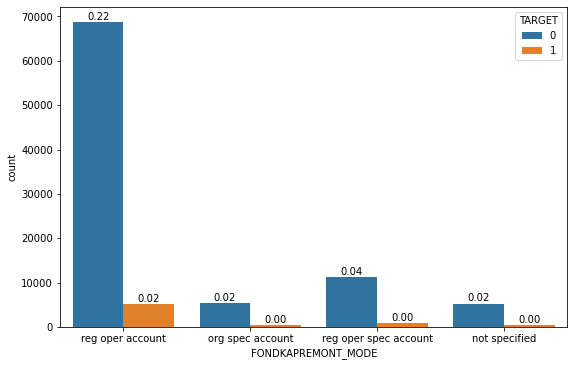

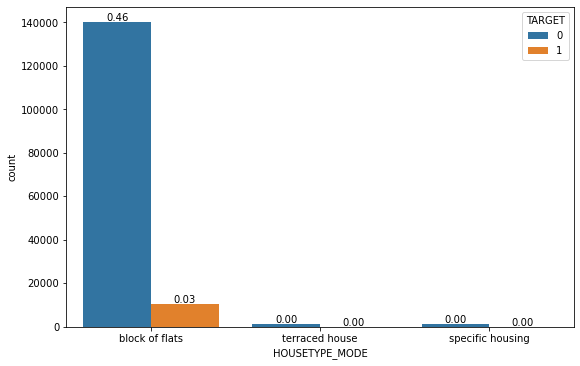

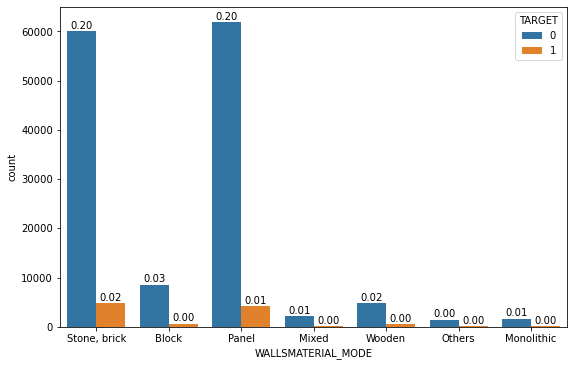

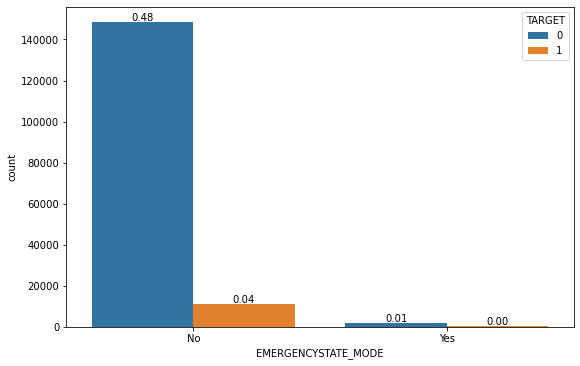

In [15]:
count = 1
for i in range(1,7):

    index = i-1
    if missing_categorical_data_train.columns[index] != "OCCUPATION_TYPE":
        plt.figure(figsize = (20,20))
        plt.subplot(3,2,count)
        count +=1
        ax = sns.countplot(x=missing_categorical_data_train.columns[index],hue="TARGET",data=missing_categorical_data_train)
        total = float(missing_categorical_data_train.shape[0])
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2,height+500,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
        plt.show()

<h4>Unique value of OCCUPATION type is more than other missing values so we visualize it seperately.

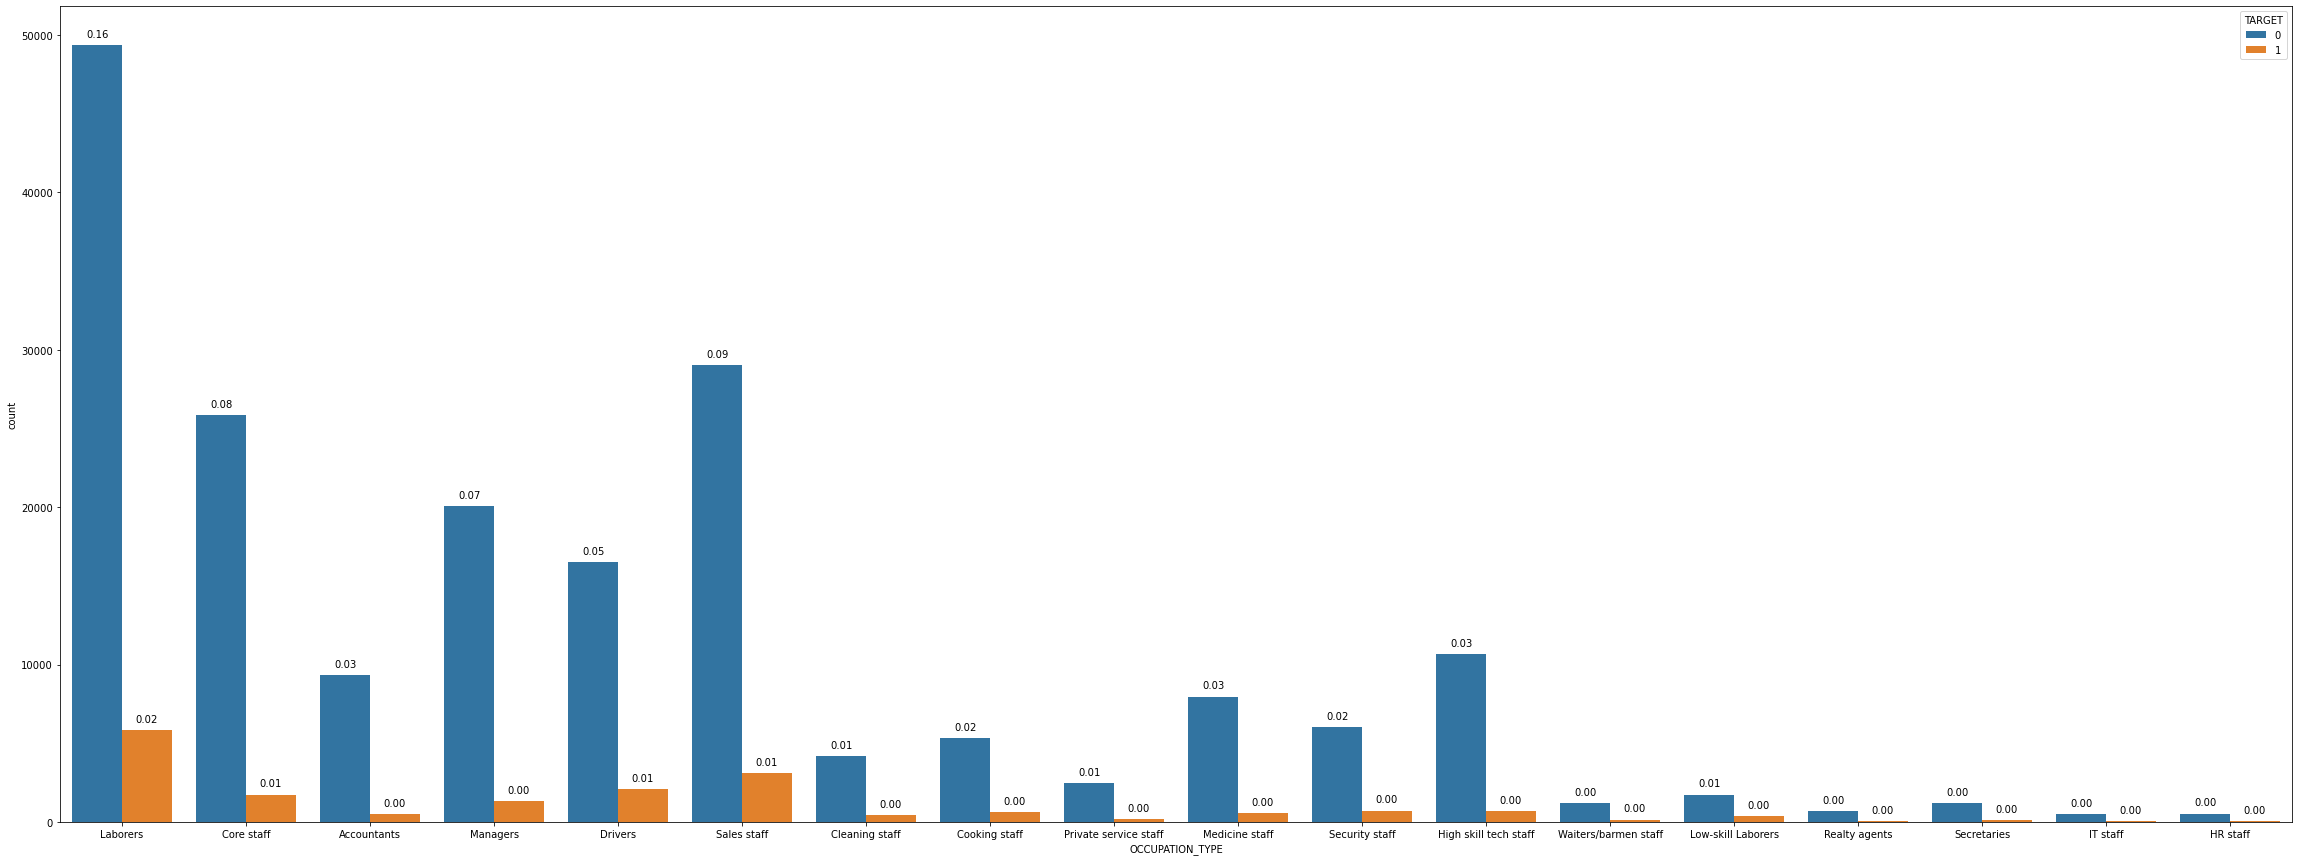

In [16]:
plt.figure(figsize=(40,15))
ax = sns.countplot(x="OCCUPATION_TYPE",hue="TARGET",data=missing_categorical_data_train)
total = float(missing_categorical_data_train.shape[0])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height+500,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
plt.show()

In [17]:
imp_category = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_category.fit(Want_to_fill_train)

train_fill = imp_category.fit_transform(Want_to_fill_train)

imp_category2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_category2.fit(Want_to_fill_test)

test_fill = imp_category2.fit_transform(Want_to_fill_test)

train_fill = pd.DataFrame(train_fill,columns=Want_to_fill_train.columns)
test_fill = pd.DataFrame(test_fill,columns=Want_to_fill_test.columns)

In [18]:
train_fill

NAME_TYPE_SUITE OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0        Unaccompanied        Laborers   reg oper account  block of flats   
1               Family      Core staff   reg oper account  block of flats   
2        Unaccompanied        Laborers   reg oper account  block of flats   
3        Unaccompanied        Laborers   reg oper account  block of flats   
4        Unaccompanied      Core staff   reg oper account  block of flats   
...                ...             ...                ...             ...   
307506   Unaccompanied     Sales staff   reg oper account  block of flats   
307507   Unaccompanied        Laborers   reg oper account  block of flats   
307508   Unaccompanied        Managers   reg oper account  block of flats   
307509   Unaccompanied        Laborers   reg oper account  block of flats   
307510   Unaccompanied        Laborers   reg oper account  block of flats   

       WALLSMATERIAL_MODE EMERGENCYSTATE_MODE TARGET  
0            Stone, brick                  No      1  
1                   Block                  No      0  
2                   Panel                  No      0  
3                   Panel                  No      0  
4                   Panel                  No      0  
...                   ...                 ...    ...  
307506       Stone, brick                  No      0  
307507       Stone, brick                  No      0  
307508              Panel                  No      0  
307509       Stone, brick                  No      1  
307510              Panel                  No      0  

[307511 rows x 7 columns]

In [19]:
test_fill

NAME_TYPE_SUITE     OCCUPATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0       Unaccompanied            Laborers   reg oper account  block of flats   
1       Unaccompanied  Low-skill Laborers   reg oper account  block of flats   
2       Unaccompanied             Drivers   reg oper account  block of flats   
3       Unaccompanied         Sales staff   reg oper account  block of flats   
4       Unaccompanied            Laborers   reg oper account  block of flats   
...               ...                 ...                ...             ...   
48739   Unaccompanied            Laborers   reg oper account  block of flats   
48740   Unaccompanied         Sales staff   reg oper account  block of flats   
48741   Unaccompanied            Laborers   reg oper account  block of flats   
48742          Family            Managers   reg oper account  block of flats   
48743   Unaccompanied          Core staff   reg oper account  block of flats   

      WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0           Stone, brick                  No  
1                  Panel                  No  
2                  Panel                  No  
3                  Panel                  No  
4                  Panel                  No  
...                  ...                 ...  
48739              Panel                  No  
48740              Panel                  No  
48741       Stone, brick                  No  
48742              Panel                  No  
48743              Panel                  No  

[48744 rows x 6 columns]

In [20]:
train_fill.isnull().sum()

NAME_TYPE_SUITE        0
OCCUPATION_TYPE        0
FONDKAPREMONT_MODE     0
HOUSETYPE_MODE         0
WALLSMATERIAL_MODE     0
EMERGENCYSTATE_MODE    0
TARGET                 0
dtype: int64

In [21]:
Application_train.drop(columns = Want_to_fill_train.columns,inplace=True)
Application_test.drop(columns= Want_to_fill_test.columns,inplace=True)
Application_train = pd.concat([Application_train,train_fill],axis=1)
Application_test = pd.concat([Application_test,test_fill],axis=1)

Check missing categorical data again

In [22]:
Want_to_fill_train = Application_train.iloc[:,Application_train.isnull().sum().values > 0].select_dtypes("object")
Want_to_fill_test = Application_test.iloc[:,Application_test.isnull().sum().values >0].select_dtypes("object")

In [23]:
Want_to_fill_train.shape

(307511, 0)

So we do it 

We want to label encoder and one-hot encoder by using label encoder with unique values <= 2 and one-hot encoder with unique values > 2.

First, we do one-hot encoder

In [24]:
Application_train = Application_train.astype({"TARGET":float})

In [25]:
data1 = Application_train.iloc[:,Application_train.isnull().sum().values==0].select_dtypes("object")
series1 = data1.apply(pd.Series.nunique, axis = 0)

list_one_hot_encoder = []
list_label = []
for i in range(len(series1)):
  if series1.values[i] <= 2:
    list_label.append(series1.index[i])
  else:
    list_one_hot_encoder.append(series1.index[i])

In [26]:
enc = OneHotEncoder()
enc.fit(Application_train[list_one_hot_encoder])
category = []
count = 1
for i in enc.categories_:
  for j in i:
    category.append(j)
    count+=1
Category_to_df = enc.transform(Application_train[list_one_hot_encoder]).toarray()
Category_to_df = pd.DataFrame(Category_to_df,columns=category)

Second,we do label encoder

In [27]:
label_df = Application_train[list_label]
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Cash loans","NAME_CONTRACT_TYPE"] = 0
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Revolving loans","NAME_CONTRACT_TYPE"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "Y","FLAG_OWN_CAR"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "N","FLAG_OWN_CAR"] = 0
label_df.loc[label_df.FLAG_OWN_REALTY == "Y","FLAG_OWN_REALTY"] = 1
label_df.loc[label_df.FLAG_OWN_REALTY == "N","FLAG_OWN_REALTY"] = 0
Category_to_df=pd.concat([Category_to_df,label_df],axis=1)

In [28]:
Category_to_df

F    M  XNA  Businessman  Commercial associate  Maternity leave  \
0       0.0  1.0  0.0          0.0                   0.0              0.0   
1       1.0  0.0  0.0          0.0                   0.0              0.0   
2       0.0  1.0  0.0          0.0                   0.0              0.0   
3       1.0  0.0  0.0          0.0                   0.0              0.0   
4       0.0  1.0  0.0          0.0                   0.0              0.0   
...     ...  ...  ...          ...                   ...              ...   
307506  0.0  1.0  0.0          0.0                   0.0              0.0   
307507  1.0  0.0  0.0          0.0                   0.0              0.0   
307508  1.0  0.0  0.0          0.0                   0.0              0.0   
307509  1.0  0.0  0.0          0.0                   1.0              0.0   
307510  1.0  0.0  0.0          0.0                   1.0              0.0   

        Pensioner  State servant  Student  Unemployed  ...  Mixed  Monolithic  \
0             0.0            0.0      0.0         0.0  ...    0.0         0.0   
1             0.0            1.0      0.0         0.0  ...    0.0         0.0   
2             0.0            0.0      0.0         0.0  ...    0.0         0.0   
3             0.0            0.0      0.0         0.0  ...    0.0         0.0   
4             0.0            0.0      0.0         0.0  ...    0.0         0.0   
...           ...            ...      ...         ...  ...    ...         ...   
307506        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307507        1.0            0.0      0.0         0.0  ...    0.0         0.0   
307508        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307509        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307510        0.0            0.0      0.0         0.0  ...    0.0         0.0   

        Others  Panel  Stone, brick  Wooden  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
0          0.0    0.0           1.0     0.0                   0             0   
1          0.0    0.0           0.0     0.0                   0             0   
2          0.0    1.0           0.0     0.0                   1             1   
3          0.0    1.0           0.0     0.0                   0             0   
4          0.0    1.0           0.0     0.0                   0             0   
...        ...    ...           ...     ...                 ...           ...   
307506     0.0    0.0           1.0     0.0                   0             0   
307507     0.0    0.0           1.0     0.0                   0             0   
307508     0.0    1.0           0.0     0.0                   0             0   
307509     0.0    0.0           1.0     0.0                   0             0   
307510     0.0    1.0           0.0     0.0                   0             0   

        FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  
0                     1                   No  
1                     0                   No  
2                     1                   No  
3                     1                   No  
4                     1                   No  
...                 ...                  ...  
307506                0                   No  
307507                1                   No  
307508                1                   No  
307509                1                   No  
307510                0                   No  

[307511 rows x 136 columns]

In [29]:
Category_to_df.loc[Category_to_df.EMERGENCYSTATE_MODE == "Yes","EMERGENCYSTATE_MODE"] = 1
Category_to_df.loc[Category_to_df.EMERGENCYSTATE_MODE == "No","EMERGENCYSTATE_MODE"] = 0

In [30]:
Category_to_df

F    M  XNA  Businessman  Commercial associate  Maternity leave  \
0       0.0  1.0  0.0          0.0                   0.0              0.0   
1       1.0  0.0  0.0          0.0                   0.0              0.0   
2       0.0  1.0  0.0          0.0                   0.0              0.0   
3       1.0  0.0  0.0          0.0                   0.0              0.0   
4       0.0  1.0  0.0          0.0                   0.0              0.0   
...     ...  ...  ...          ...                   ...              ...   
307506  0.0  1.0  0.0          0.0                   0.0              0.0   
307507  1.0  0.0  0.0          0.0                   0.0              0.0   
307508  1.0  0.0  0.0          0.0                   0.0              0.0   
307509  1.0  0.0  0.0          0.0                   1.0              0.0   
307510  1.0  0.0  0.0          0.0                   1.0              0.0   

        Pensioner  State servant  Student  Unemployed  ...  Mixed  Monolithic  \
0             0.0            0.0      0.0         0.0  ...    0.0         0.0   
1             0.0            1.0      0.0         0.0  ...    0.0         0.0   
2             0.0            0.0      0.0         0.0  ...    0.0         0.0   
3             0.0            0.0      0.0         0.0  ...    0.0         0.0   
4             0.0            0.0      0.0         0.0  ...    0.0         0.0   
...           ...            ...      ...         ...  ...    ...         ...   
307506        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307507        1.0            0.0      0.0         0.0  ...    0.0         0.0   
307508        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307509        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307510        0.0            0.0      0.0         0.0  ...    0.0         0.0   

        Others  Panel  Stone, brick  Wooden  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
0          0.0    0.0           1.0     0.0                   0             0   
1          0.0    0.0           0.0     0.0                   0             0   
2          0.0    1.0           0.0     0.0                   1             1   
3          0.0    1.0           0.0     0.0                   0             0   
4          0.0    1.0           0.0     0.0                   0             0   
...        ...    ...           ...     ...                 ...           ...   
307506     0.0    0.0           1.0     0.0                   0             0   
307507     0.0    0.0           1.0     0.0                   0             0   
307508     0.0    1.0           0.0     0.0                   0             0   
307509     0.0    0.0           1.0     0.0                   0             0   
307510     0.0    1.0           0.0     0.0                   0             0   

        FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  
0                     1                    0  
1                     0                    0  
2                     1                    0  
3                     1                    0  
4                     1                    0  
...                 ...                  ...  
307506                0                    0  
307507                1                    0  
307508                1                    0  
307509                1                    0  
307510                0                    0  

[307511 rows x 136 columns]

In [31]:
data1 = Application_test.iloc[:,Application_test.isnull().sum().values==0].select_dtypes("object")
series2 = data1.apply(pd.Series.nunique, axis = 0)

In [32]:
label_df = Application_test[list_label]
label_df

NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY EMERGENCYSTATE_MODE
0             Cash loans            N               Y                  No
1             Cash loans            N               Y                  No
2             Cash loans            Y               Y                  No
3             Cash loans            N               Y                  No
4             Cash loans            Y               N                  No
...                  ...          ...             ...                 ...
48739         Cash loans            N               Y                  No
48740         Cash loans            N               N                  No
48741         Cash loans            Y               Y                  No
48742         Cash loans            N               N                  No
48743         Cash loans            Y               N                  No

[48744 rows x 4 columns]

In [33]:
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Cash loans","NAME_CONTRACT_TYPE"] = 0
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Revolving loans","NAME_CONTRACT_TYPE"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "Y","FLAG_OWN_CAR"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "N","FLAG_OWN_CAR"] = 0
label_df.loc[label_df.FLAG_OWN_REALTY == "Y","FLAG_OWN_REALTY"] = 1
label_df.loc[label_df.FLAG_OWN_REALTY == "N","FLAG_OWN_REALTY"] = 0
label_df.loc[label_df.EMERGENCYSTATE_MODE == "Yes","EMERGENCYSTATE_MODE"] = 1
label_df.loc[label_df.EMERGENCYSTATE_MODE == "No","EMERGENCYSTATE_MODE"] = 0

In [34]:
enc = OneHotEncoder()
enc.fit(Application_test[list_one_hot_encoder])
category = []
for i in enc.categories_:
  for j in i:
    category.append(j)
Category_to_df_test = enc.transform(Application_test[list_one_hot_encoder]).toarray()
Category_to_df_test = pd.DataFrame(Category_to_df_test,columns=category)

In [35]:
Category_to_df_test = pd.concat([Category_to_df_test,label_df],axis=1)
Category_to_df_test


F    M  Businessman  Commercial associate  Pensioner  State servant  \
0      1.0  0.0          0.0                   0.0        0.0            0.0   
1      0.0  1.0          0.0                   0.0        0.0            0.0   
2      0.0  1.0          0.0                   0.0        0.0            0.0   
3      1.0  0.0          0.0                   0.0        0.0            0.0   
4      0.0  1.0          0.0                   0.0        0.0            0.0   
...    ...  ...          ...                   ...        ...            ...   
48739  1.0  0.0          0.0                   0.0        0.0            0.0   
48740  1.0  0.0          0.0                   1.0        0.0            0.0   
48741  1.0  0.0          0.0                   1.0        0.0            0.0   
48742  0.0  1.0          0.0                   1.0        0.0            0.0   
48743  1.0  0.0          0.0                   0.0        0.0            0.0   

       Student  Unemployed  Working  Academic degree  ...  Mixed  Monolithic  \
0          0.0         0.0      1.0              0.0  ...    0.0         0.0   
1          0.0         0.0      1.0              0.0  ...    0.0         0.0   
2          0.0         0.0      1.0              0.0  ...    0.0         0.0   
3          0.0         0.0      1.0              0.0  ...    0.0         0.0   
4          0.0         0.0      1.0              0.0  ...    0.0         0.0   
...        ...         ...      ...              ...  ...    ...         ...   
48739      0.0         0.0      1.0              0.0  ...    0.0         0.0   
48740      0.0         0.0      0.0              0.0  ...    0.0         0.0   
48741      0.0         0.0      0.0              0.0  ...    0.0         0.0   
48742      0.0         0.0      0.0              0.0  ...    0.0         0.0   
48743      0.0         0.0      1.0              0.0  ...    0.0         0.0   

       Others  Panel  Stone, brick  Wooden  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
0         0.0    0.0           1.0     0.0                   0             0   
1         0.0    1.0           0.0     0.0                   0             0   
2         0.0    1.0           0.0     0.0                   0             1   
3         0.0    1.0           0.0     0.0                   0             0   
4         0.0    1.0           0.0     0.0                   0             1   
...       ...    ...           ...     ...                 ...           ...   
48739     0.0    1.0           0.0     0.0                   0             0   
48740     0.0    1.0           0.0     0.0                   0             0   
48741     0.0    0.0           1.0     0.0                   0             1   
48742     0.0    1.0           0.0     0.0                   0             0   
48743     0.0    1.0           0.0     0.0                   0             1   

       FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  
0                    1                    0  
1                    1                    0  
2                    1                    0  
3                    1                    0  
4                    0                    0  
...                ...                  ...  
48739                1                    0  
48740                0                    0  
48741                1                    0  
48742                0                    0  
48743                0                    0  

[48744 rows x 133 columns]

In [36]:
category_train = Category_to_df
category_test = Category_to_df_test

In [37]:
Category_to_df

F    M  XNA  Businessman  Commercial associate  Maternity leave  \
0       0.0  1.0  0.0          0.0                   0.0              0.0   
1       1.0  0.0  0.0          0.0                   0.0              0.0   
2       0.0  1.0  0.0          0.0                   0.0              0.0   
3       1.0  0.0  0.0          0.0                   0.0              0.0   
4       0.0  1.0  0.0          0.0                   0.0              0.0   
...     ...  ...  ...          ...                   ...              ...   
307506  0.0  1.0  0.0          0.0                   0.0              0.0   
307507  1.0  0.0  0.0          0.0                   0.0              0.0   
307508  1.0  0.0  0.0          0.0                   0.0              0.0   
307509  1.0  0.0  0.0          0.0                   1.0              0.0   
307510  1.0  0.0  0.0          0.0                   1.0              0.0   

        Pensioner  State servant  Student  Unemployed  ...  Mixed  Monolithic  \
0             0.0            0.0      0.0         0.0  ...    0.0         0.0   
1             0.0            1.0      0.0         0.0  ...    0.0         0.0   
2             0.0            0.0      0.0         0.0  ...    0.0         0.0   
3             0.0            0.0      0.0         0.0  ...    0.0         0.0   
4             0.0            0.0      0.0         0.0  ...    0.0         0.0   
...           ...            ...      ...         ...  ...    ...         ...   
307506        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307507        1.0            0.0      0.0         0.0  ...    0.0         0.0   
307508        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307509        0.0            0.0      0.0         0.0  ...    0.0         0.0   
307510        0.0            0.0      0.0         0.0  ...    0.0         0.0   

        Others  Panel  Stone, brick  Wooden  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
0          0.0    0.0           1.0     0.0                   0             0   
1          0.0    0.0           0.0     0.0                   0             0   
2          0.0    1.0           0.0     0.0                   1             1   
3          0.0    1.0           0.0     0.0                   0             0   
4          0.0    1.0           0.0     0.0                   0             0   
...        ...    ...           ...     ...                 ...           ...   
307506     0.0    0.0           1.0     0.0                   0             0   
307507     0.0    0.0           1.0     0.0                   0             0   
307508     0.0    1.0           0.0     0.0                   0             0   
307509     0.0    0.0           1.0     0.0                   0             0   
307510     0.0    1.0           0.0     0.0                   0             0   

        FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  
0                     1                    0  
1                     0                    0  
2                     1                    0  
3                     1                    0  
4                     1                    0  
...                 ...                  ...  
307506                0                    0  
307507                1                    0  
307508                1                    0  
307509                1                    0  
307510                0                    0  

[307511 rows x 136 columns]

In [38]:
Train_Null_category = Application_train.select_dtypes("object")
Train_Null_category = Train_Null_category.iloc[:,Train_Null_category.isnull().sum().values>0]
Train_Null_category 

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[307511 rows x 0 columns]

In [39]:
Test_Null_category = Application_test.select_dtypes("object")
Test_Null_category = Test_Null_category.iloc[:,Test_Null_category.isnull().sum().values>0]
Test_Null_category

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[48744 rows x 0 columns]

<h4>Visualize other categorical data.

In [40]:
data1 = Application_train.select_dtypes("object")
data_viz = data1.iloc[:,:data1.shape[1]-6]
data_viz["TARGET"] = Application_train["TARGET"]

In [41]:
check_series_unique = data_viz.apply(pd.Series.nunique)
check_series_unique 

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
TARGET                         2
dtype: int64

In [42]:
data_viz

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0              Cash loans           M            N               Y   
1              Cash loans           F            N               N   
2         Revolving loans           M            Y               Y   
3              Cash loans           F            N               Y   
4              Cash loans           M            N               Y   
...                   ...         ...          ...             ...   
307506         Cash loans           M            N               N   
307507         Cash loans           F            N               Y   
307508         Cash loans           F            N               Y   
307509         Cash loans           F            N               Y   
307510         Cash loans           F            N               N   

            NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0                    Working  Secondary / secondary special   
1              State servant               Higher education   
2                    Working  Secondary / secondary special   
3                    Working  Secondary / secondary special   
4                    Working  Secondary / secondary special   
...                      ...                            ...   
307506               Working  Secondary / secondary special   
307507             Pensioner  Secondary / secondary special   
307508               Working               Higher education   
307509  Commercial associate  Secondary / secondary special   
307510  Commercial associate               Higher education   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE WEEKDAY_APPR_PROCESS_START  \
0       Single / not married  House / apartment                  WEDNESDAY   
1                    Married  House / apartment                     MONDAY   
2       Single / not married  House / apartment                     MONDAY   
3             Civil marriage  House / apartment                  WEDNESDAY   
4       Single / not married  House / apartment                   THURSDAY   
...                      ...                ...                        ...   
307506             Separated       With parents                   THURSDAY   
307507                 Widow  House / apartment                     MONDAY   
307508             Separated  House / apartment                   THURSDAY   
307509               Married  House / apartment                  WEDNESDAY   
307510               Married  House / apartment                   THURSDAY   

             ORGANIZATION_TYPE  TARGET  
0       Business Entity Type 3     1.0  
1                       School     0.0  
2                   Government     0.0  
3       Business Entity Type 3     0.0  
4                     Religion     0.0  
...                        ...     ...  
307506                Services     0.0  
307507                     XNA     0.0  
307508                  School     0.0  
307509  Business Entity Type 1     1.0  
307510  Business Entity Type 3     0.0  

[307511 rows x 11 columns]

In [43]:
data_viz.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'TARGET'],
      dtype='object')

In [44]:
count = 1
"""for i in range(1,11):
    index = i-1
    if data_viz.columns[index] not in ["OCCUPATION_TYPE","ORGANIZATION_TYPE"]:
        fig,ax = plt.subplots(nrows=6, ncols=2)
        plt.figure(figsize = (25,72))
        plt.subplot(6,2,count)
        count +=1
        axe=sns.countplot(x=data_viz.columns[index],hue="TARGET",data=data_viz)
        total = float(missing_categorical_data_train.shape[0])
        for p in axe.patches:
            height = p.get_height()
            axe.text(p.get_x()+p.get_width()/2,height+500,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
        fig.show()"""


'for i in range(1,11):\n    index = i-1\n    if data_viz.columns[index] not in ["OCCUPATION_TYPE","ORGANIZATION_TYPE"]:\n        fig,ax = plt.subplots(nrows=6, ncols=2)\n        plt.figure(figsize = (25,72))\n        plt.subplot(6,2,count)\n        count +=1\n        axe=sns.countplot(x=data_viz.columns[index],hue="TARGET",data=data_viz)\n        total = float(missing_categorical_data_train.shape[0])\n        for p in axe.patches:\n            height = p.get_height()\n            axe.text(p.get_x()+p.get_width()/2,height+500,\n            \'{:1.2f}\'.format(float(height/total)),\n            ha="center") \n        fig.show()'

In [45]:
data_viz.shape[1]

11

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


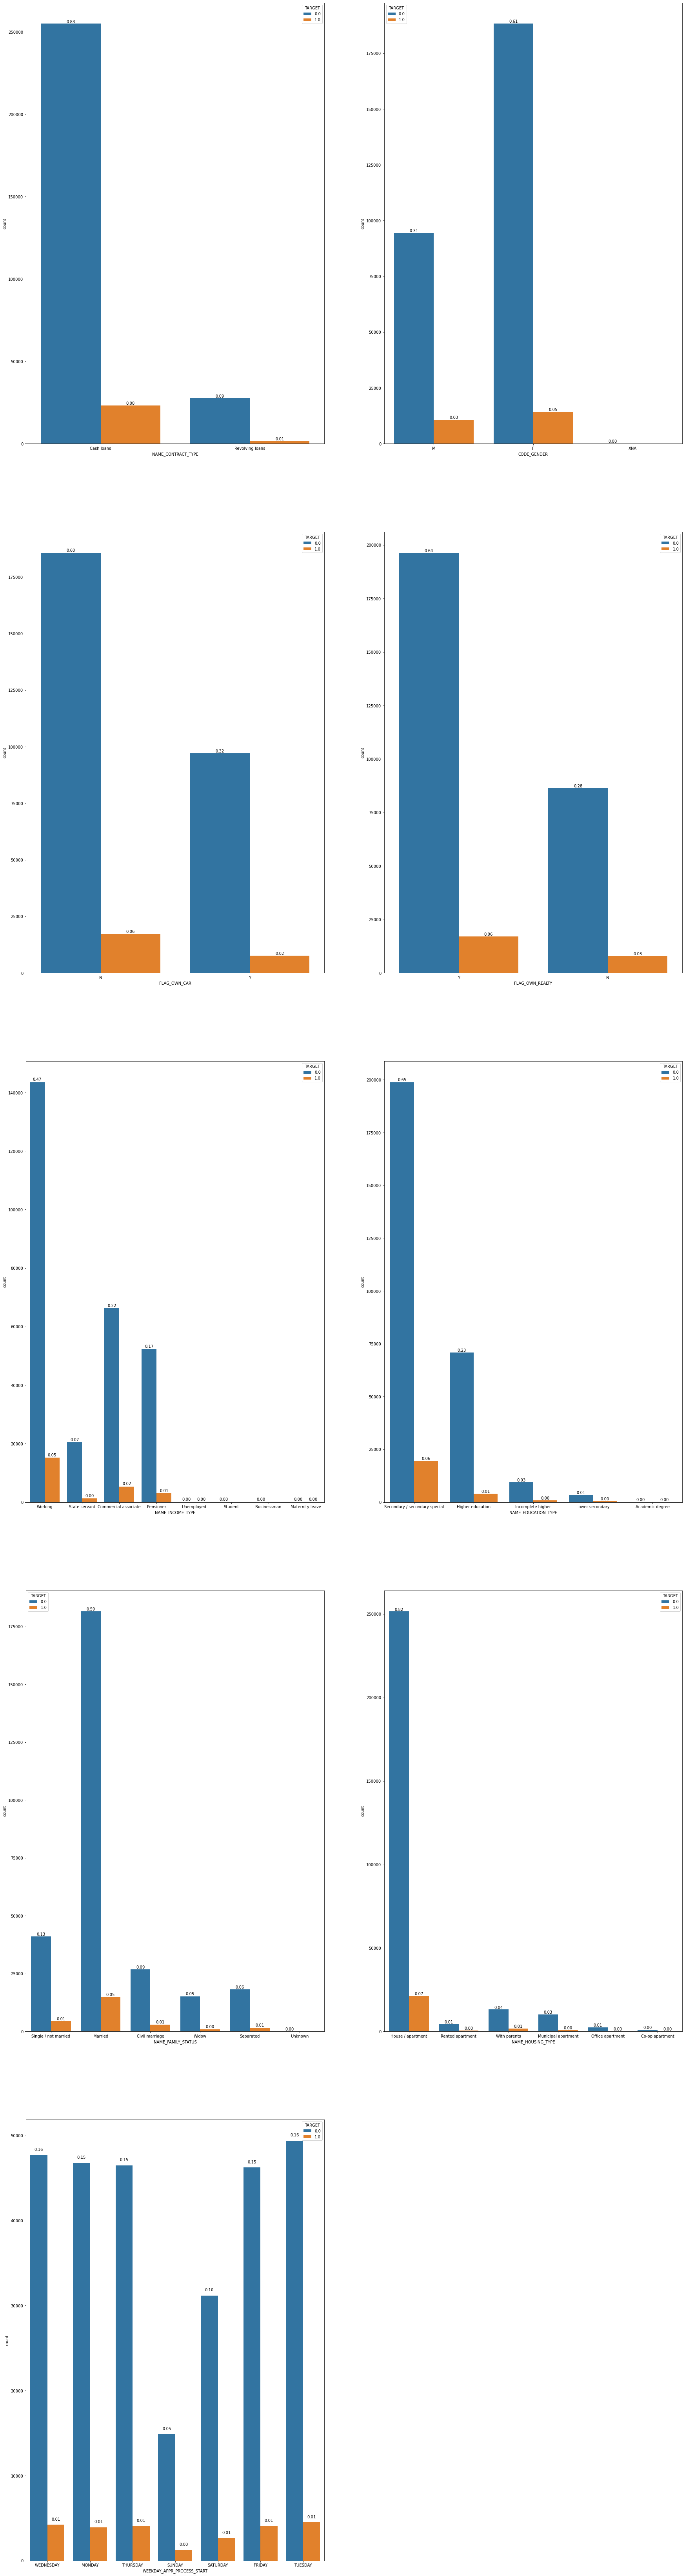

In [46]:
f = plt.figure(figsize=(30,120))
count = 1
for i in range(data_viz.shape[1]-2):
    fig =  f.add_subplot(5,2,count)
    axes = sns.countplot(x=data_viz.columns[i],hue="TARGET",data=data_viz)
    total = float(Application_train.shape[0])
    for p in axes.patches:
        height = p.get_height()
        axes.text(p.get_x()+p.get_width()/2,height+500,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
    count +=1
    

Visualize ORGANIZATION_TYPE individually

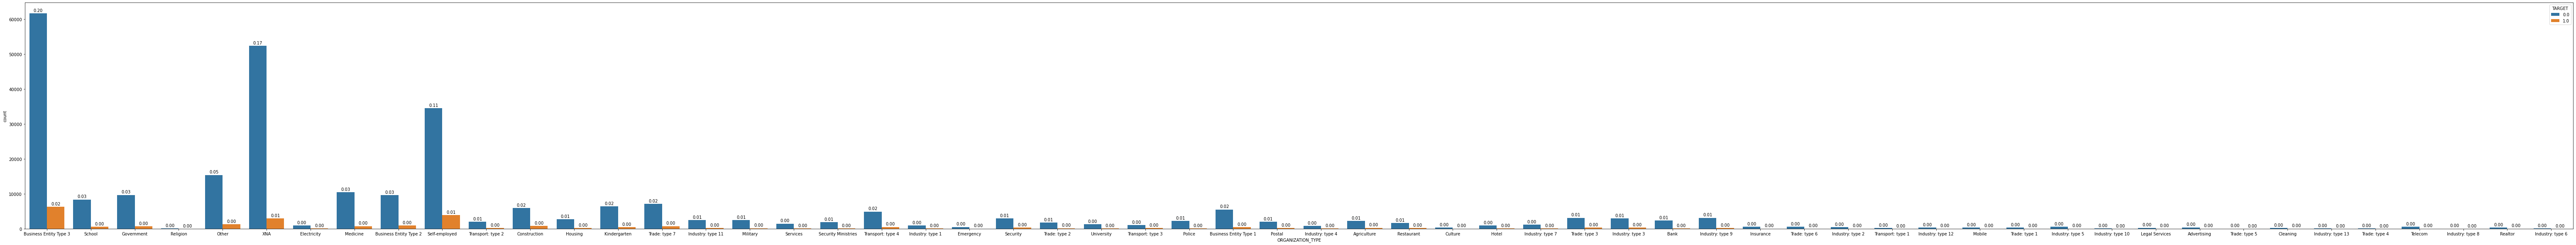

In [47]:
plt.figure(figsize=(110,10))
axes = sns.countplot(x=data_viz.columns[-2],hue="TARGET",data=data_viz)
total = float(Application_train.shape[0])
for p in axes.patches:
        height = p.get_height()
        axes.text(p.get_x()+p.get_width()/2,height+500,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
plt.show()

In [48]:
category_df_train = Category_to_df
category_df_test = Category_to_df_test

In [49]:
columns_drop = [2,5,20]
list_index = []
for i in range(category_df_train.shape[1]):
  if i not in columns_drop:
    list_index.append(i)

<h2>Finished Categorical data in Application train and Application test

When we finished to fill category data, we will deal with numerical data in Application train and test.

In [50]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Numerical_data_train = Application_train.select_dtypes(include=numerics)
Numerical_data_test = Application_test.select_dtypes(include=numerics)
Y_train = Application_train.TARGET

We change outlier to be missing value.

In [51]:
Application_train.columns[:100]

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPL

In [52]:
Viz_data = Application_train[["DAYS_EMPLOYED","TARGET"]]
Viz_data_test = Application_test[["DAYS_EMPLOYED"]]

In [53]:
Viz_data

DAYS_EMPLOYED  TARGET
0                -637     1.0
1               -1188     0.0
2                -225     0.0
3               -3039     0.0
4               -3038     0.0
...               ...     ...
307506           -236     0.0
307507         365243     0.0
307508          -7921     0.0
307509          -4786     1.0
307510          -1262     0.0

[307511 rows x 2 columns]

In [57]:
Viz_data

DAYS_EMPLOYED  TARGET DAYS_EMPLOYED_Outlier
0                 637     1.0                    No
1                1188     0.0                    No
2                 225     0.0                    No
3                3039     0.0                    No
4                3038     0.0                    No
...               ...     ...                   ...
307506            236     0.0                    No
307507         365243     0.0                   Yes
307508           7921     0.0                    No
307509           4786     1.0                    No
307510           1262     0.0                    No

[307511 rows x 3 columns]

In [55]:
Viz_data = Viz_data.apply(lambda x:abs(x))
Viz_data.loc[Viz_data.DAYS_EMPLOYED.values > 36500,"DAYS_EMPLOYED_Outlier"] = "Yes"
Viz_data.loc[Viz_data.DAYS_EMPLOYED.values <= 36500,"DAYS_EMPLOYED_Outlier"] = "No"
Viz_data

TypeError: bad operand type for abs(): 'str'

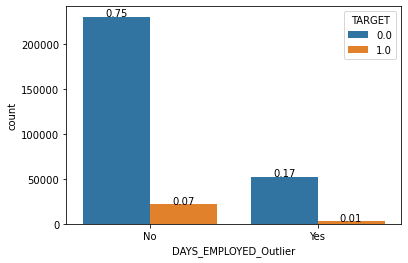

In [58]:
axes = sns.countplot(x="DAYS_EMPLOYED_Outlier",hue="TARGET",data=Viz_data)
total = float(Application_train.shape[0])
for p in axes.patches:
        height = p.get_height()
        axes.text(p.get_x()+p.get_width()/2,height+500,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
plt.show()

Check outlier data in test data

In [59]:
Viz_data_test = Viz_data_test.apply(lambda x:abs(x))
Viz_data_test.loc[Viz_data_test.DAYS_EMPLOYED.values > 36500,"DAYS_EMPLOYED_Outlier"] = "Yes"
Viz_data_test.loc[Viz_data_test.DAYS_EMPLOYED.values <= 36500,"DAYS_EMPLOYED_Outlier"] = "No"
Viz_data_test

DAYS_EMPLOYED DAYS_EMPLOYED_Outlier
0               2329                    No
1               4469                    No
2               4458                    No
3               1866                    No
4               2191                    No
...              ...                   ...
48739           5169                    No
48740           1149                    No
48741           3037                    No
48742           2731                    No
48743            633                    No

[48744 rows x 2 columns]

We saw that when days employed is outlier, percentage that customer will repaying the loan is more than normal days employed data.

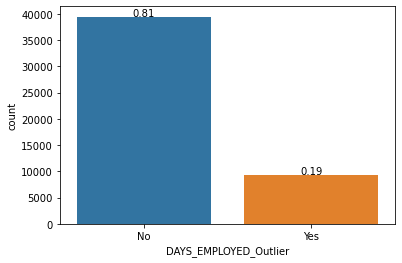

In [60]:
axes = sns.countplot(data=Viz_data_test,x="DAYS_EMPLOYED_Outlier")
total = float(Application_test.shape[0])
for p in axes.patches:
        height = p.get_height()
        axes.text(p.get_x()+p.get_width()/2,height+100,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
plt.show()

19% of days_employed_outlier in application test is outlier

In [61]:
category_train["DAY_EMPLOY_Outlier"] = Viz_data["DAYS_EMPLOYED_Outlier"]
category_test["DAY_EMPLOY_Outlier"] = Viz_data_test["DAYS_EMPLOYED_Outlier"]

In [62]:
category_train.loc[category_train.DAY_EMPLOY_Outlier == "No","DAY_EMPLOY_Outlier"] = 0
category_train.loc[category_train.DAY_EMPLOY_Outlier == "Yes","DAY_EMPLOY_Outlier"] = 1
category_test.loc[category_test.DAY_EMPLOY_Outlier == "No","DAY_EMPLOY_Outlier"] = 0
category_test.loc[category_test.DAY_EMPLOY_Outlier == "Yes","DAY_EMPLOY_Outlier"] = 1


In [63]:
Application_train.loc[Application_train['DAYS_EMPLOYED'] == 365243,"DAYS_EMPLOYED"] = np.nan 
Application_test.loc[Application_test['DAYS_EMPLOYED'] == 365243,"DAYS_EMPLOYED"] = np.nan 

DAYS_EMPLOYED = 365243 days is impossible. so we change DAYS_EMPLOY which equal 365243 to np.nan

In [64]:
Application_train.OWN_CAR_AGE.fillna(0,inplace=True)
Application_test.OWN_CAR_AGE.fillna(0,inplace=True)

When own car age is missing we found that the customer doesn't have a car,we can fill zero with the missing values.

In [65]:
columns = ['AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR']
for i in columns:
  Application_train[i].fillna(0,inplace=True)
  Application_test[i].fillna(0,inplace=True)

AMT_REQ_CREDIT differ by times like own car age we fill missing values with 0

We do feature engineering with SUM_REQ_CREDIT_BUREAU by sum AMT_REQ_CREDIT_BUREAU-

In [66]:
Application_train["SUM_REQ_CREDIT_BUREAU"] = Application_train[columns].sum(axis=1)
Application_test["SUM_REQ_CREDIT_BUREAU"] = Application_test[columns].sum(axis=1)

And now we fill missing numerical data in Application train and test with median.

In [67]:
Application_train_only_numeric = Application_train.select_dtypes(numerics)
Application_train_only_numeric
imp_mean = SimpleImputer(missing_values=np.nan,strategy='median')
imp_mean.fit(Application_train_only_numeric)

SimpleImputer(strategy='median')

In [68]:
new_df = imp_mean.transform(Application_train_only_numeric)
new_df = pd.DataFrame(new_df,columns=Application_train_only_numeric.columns)

In [69]:
new_df = new_df.apply(lambda x:abs(x))

In [70]:
imp_mean = SimpleImputer(missing_values=np.nan,strategy="median")
imp_mean.fit(Application_test.select_dtypes(numerics))

SimpleImputer(strategy='median')

In [71]:
new_df_test = imp_mean.transform(Application_test.select_dtypes(numerics))
new_df_test = pd.DataFrame(new_df_test,columns=Application_test.select_dtypes(numerics).columns)

In [72]:
new_df.drop(columns="TARGET",inplace=True)

In [73]:
new_df_test = new_df_test.apply(lambda x:abs(x))

<h4> When we do label encoder, we need to change type object from object to float or int.

In [74]:
Feature_train = pd.concat([category_train,new_df],axis=1)
Feature_test = pd.concat([category_test,new_df_test],axis=1)

columns_to_change_test = Feature_test.iloc[:,Feature_test.dtypes.values == "object"].columns
columns_to_change_train= Feature_train.iloc[:,Feature_train.dtypes.values == "object"].columns

change_convert = Feature_train[columns_to_change_train]
change_convert_test = Feature_test[columns_to_change_test]

convert_dict = {'NAME_CONTRACT_TYPE':float,
                "FLAG_OWN_CAR":float,
                "FLAG_OWN_REALTY":float}

change_convert=change_convert.astype(convert_dict)
change_convert_test=change_convert_test.astype(convert_dict)

Feature_train.drop(columns=change_convert.columns,inplace=True)
Feature_test.drop(columns=change_convert_test.columns,inplace=True)

Feature_train = pd.concat([Feature_train,change_convert],axis=1)
Feature_test = pd.concat([Feature_test,change_convert_test],axis=1)

<h3>Doing Feature Engineering

In [75]:
columns1 = ["AMT_ANNUITY","AMT_CREDIT","AMT_GOODS_PRICE","AMT_INCOME_TOTAL"]
Amt_numerical_data = Feature_train[columns1]
Amt_numerical_data["TARGET"] = Y_train

In [76]:
Amt_numerical_data_test = Feature_test[columns1]

In [77]:
Feature_train.drop(columns=columns1,inplace=True)
Feature_test.drop(columns=columns1,inplace=True)

<h4> Doing ratio data with AMT- feature

In [78]:
Amt_numerical_data["LOAN_per_credit_ratio"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_CREDIT"]
Amt_numerical_data_test["LOAN_per_credit_ratio"] = Amt_numerical_data_test["AMT_GOODS_PRICE"]/Amt_numerical_data_test["AMT_CREDIT"]

Amt_numerical_data["Ratio_annuity_per_income"] = Amt_numerical_data["AMT_ANNUITY"]/Amt_numerical_data["AMT_INCOME_TOTAL"]
Amt_numerical_data_test["Ratio_annuity_per_income"] = Amt_numerical_data_test["AMT_ANNUITY"]/Amt_numerical_data_test["AMT_INCOME_TOTAL"]

Amt_numerical_data["CREDIT_PER_INCOME_RATIO"] = Amt_numerical_data["AMT_CREDIT"]/Amt_numerical_data["AMT_INCOME_TOTAL"]
Amt_numerical_data_test["CREDIT_PER_INCOME_RATIO"] = Amt_numerical_data_test["AMT_CREDIT"]/Amt_numerical_data_test["AMT_INCOME_TOTAL"]

Amt_numerical_data["Year_customer_paid"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_ANNUITY"]
Amt_numerical_data_test["Year_customer_paid"] = Amt_numerical_data_test["AMT_GOODS_PRICE"]/Amt_numerical_data_test["AMT_ANNUITY"]

Amt_numerical_data["Ratio_credit_with_annuity"] = Amt_numerical_data["AMT_CREDIT"]/Amt_numerical_data["AMT_ANNUITY"]
Amt_numerical_data_test["Ratio_credit_with_annuity"] = Amt_numerical_data_test["AMT_CREDIT"]/Amt_numerical_data_test["AMT_ANNUITY"]

Amt_numerical_data["Ratio_Good_per_income"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_INCOME_TOTAL"]
Amt_numerical_data_test["Ratio_Good_per_income"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_INCOME_TOTAL"]


In [79]:
Amt_numerical_data.drop(columns="TARGET",inplace=True)

In [80]:
Train_data = pd.concat([Feature_train,Amt_numerical_data],axis=1)
Test_data = pd.concat([Feature_test,Amt_numerical_data_test],axis=1)

Visualize AMT feature with histogram

In [81]:
Amt_numerical_data["TARGET"] = Application_train["TARGET"]
Amt_numerical_data

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0           24700.5    406597.5         351000.0          202500.0   
1           35698.5   1293502.5        1129500.0          270000.0   
2            6750.0    135000.0         135000.0           67500.0   
3           29686.5    312682.5         297000.0          135000.0   
4           21865.5    513000.0         513000.0          121500.0   
...             ...         ...              ...               ...   
307506      27558.0    254700.0         225000.0          157500.0   
307507      12001.5    269550.0         225000.0           72000.0   
307508      29979.0    677664.0         585000.0          153000.0   
307509      20205.0    370107.0         319500.0          171000.0   
307510      49117.5    675000.0         675000.0          157500.0   

        LOAN_per_credit_ratio  Ratio_annuity_per_income  \
0                    0.863262                  0.121978   
1                    0.873211                  0.132217   
2                    1.000000                  0.100000   
3                    0.949845                  0.219900   
4                    1.000000                  0.179963   
...                       ...                       ...   
307506               0.883392                  0.174971   
307507               0.834725                  0.166687   
307508               0.863260                  0.195941   
307509               0.863264                  0.118158   
307510               1.000000                  0.311857   

        CREDIT_PER_INCOME_RATIO  Year_customer_paid  \
0                      2.007889           14.210239   
1                      4.790750           31.639985   
2                      2.000000           20.000000   
3                      2.316167           10.004548   
4                      4.222222           23.461618   
...                         ...                 ...   
307506                 1.617143            8.164598   
307507                 3.743750           18.747657   
307508                 4.429176           19.513660   
307509                 2.164368           15.812918   
307510                 4.285714           13.742556   

        Ratio_credit_with_annuity  Ratio_Good_per_income  TARGET  
0                       16.461104               1.733333     1.0  
1                       36.234085               4.183333     0.0  
2                       20.000000               2.000000     0.0  
3                       10.532818               2.200000     0.0  
4                       23.461618               4.222222     0.0  
...                           ...                    ...     ...  
307506                   9.242325               1.428571     0.0  
307507                  22.459693               3.125000     0.0  
307508                  22.604623               3.823529     0.0  
307509                  18.317595               1.868421     1.0  
307510                  13.742556               4.285714     0.0  

[307511 rows x 11 columns]

In [82]:
Amt_numerical_type1 = Amt_numerical_data[Amt_numerical_data.TARGET ==0]
Amt_numerical_type2 = Amt_numerical_data[Amt_numerical_data.TARGET ==1]

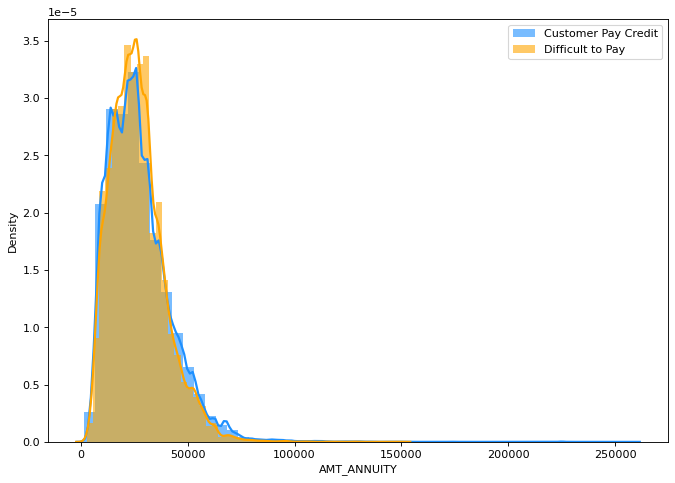

In [83]:
# Import data

x1 = Amt_numerical_type1["AMT_ANNUITY"]
x2 = Amt_numerical_type2["AMT_ANNUITY"]

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(x1, color="dodgerblue", label="Customer Pay Credit", **kwargs)
sns.distplot(x2, color="orange", label="Difficult to Pay", **kwargs)
plt.legend();

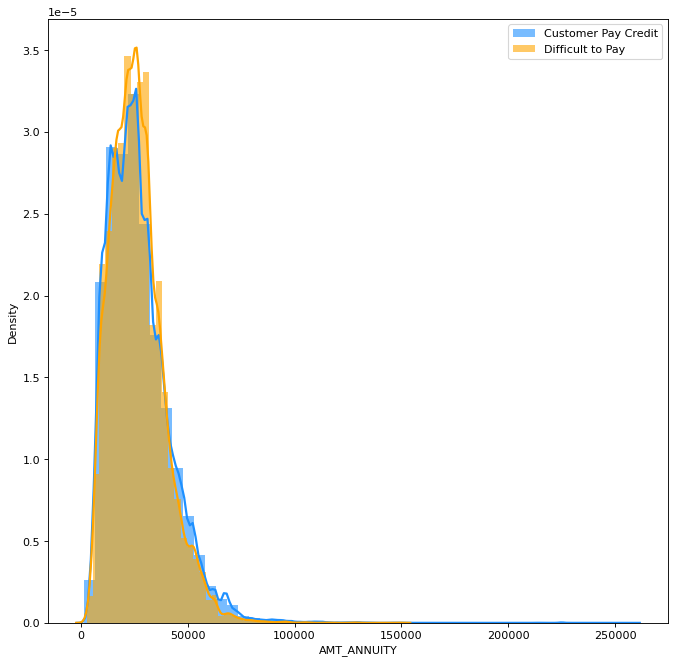

In [84]:
def create_histogram(column_name):
    x1 = Amt_numerical_type1[column_name]
    x2 = Amt_numerical_type2[column_name]
        
    kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

    plt.figure(figsize=(10,10), dpi= 80)

    sns.distplot(x1, color="dodgerblue", label="Customer Pay Credit", **kwargs)
    sns.distplot(x2, color="orange", label="Difficult to Pay", **kwargs)
    plt.legend();
create_histogram(Amt_numerical_type1.columns[0])

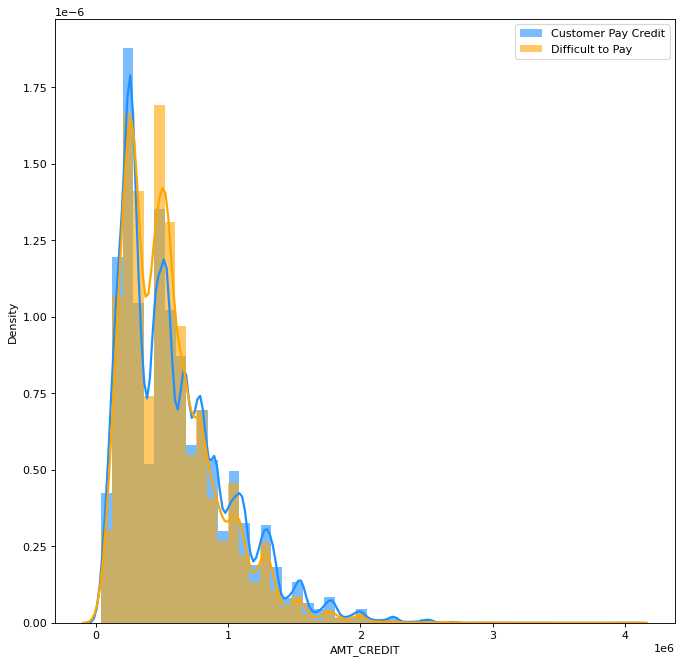

In [85]:
create_histogram(Amt_numerical_type1.columns[1])

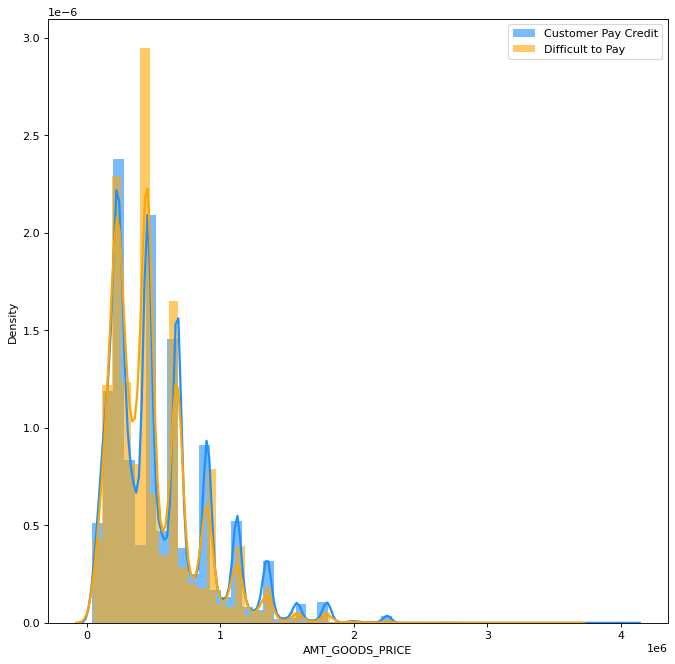

In [86]:
create_histogram(Amt_numerical_type1.columns[2])

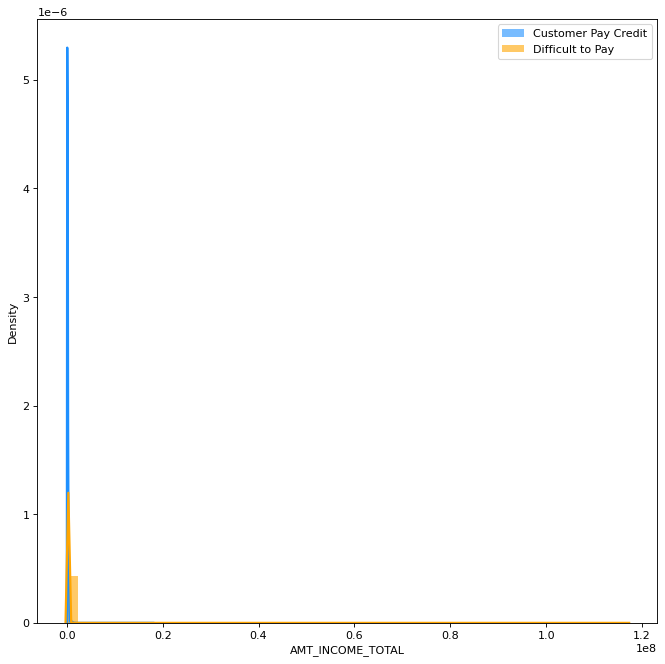

In [87]:
create_histogram(Amt_numerical_type1.columns[3])

We found problem in AMT_INCOME_TOTAL

In [88]:
Amt_numerical_type2.describe()

AMT_ANNUITY    AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
count   24825.000000  2.482500e+04     2.482500e+04      2.482500e+04   
mean    26481.744290  5.577785e+05     4.889394e+05      1.656118e+05   
std     12450.676999  3.464332e+05     3.115067e+05      7.466770e+05   
min      2722.500000  4.500000e+04     4.500000e+04      2.565000e+04   
25%     17361.000000  2.844000e+05     2.385000e+05      1.125000e+05   
50%     25263.000000  4.975200e+05     4.500000e+05      1.350000e+05   
75%     32976.000000  7.333155e+05     6.750000e+05      2.025000e+05   
max    149211.000000  4.027680e+06     3.600000e+06      1.170000e+08   

       LOAN_per_credit_ratio  Ratio_annuity_per_income  \
count           24825.000000              24825.000000   
mean                0.880448                  0.185482   
std                 0.108043                  0.094497   
min                 0.375000                  0.000224   
25%                 0.825626                  0.120000   
50%                 0.873210                  0.169294   
75%                 1.000000                  0.233640   
max                 3.333333                  1.875965   

       CREDIT_PER_INCOME_RATIO  Year_customer_paid  Ratio_credit_with_annuity  \
count             24825.000000        24825.000000               24825.000000   
mean                  3.887438           18.203096                  20.764818   
std                   2.627348            6.590212                   7.200932   
min                   0.004808            6.884682                   8.036791   
25%                   2.130435           13.220518                  14.964086   
50%                   3.253143           16.975047                  20.000000   
75%                   4.991667           21.453089                  25.217130   
max                  84.736842           66.666667                  45.295526   

       Ratio_Good_per_income   TARGET  
count           24825.000000  24825.0  
mean                3.401605      1.0  
std                 2.357588      0.0  
min                 0.003885      1.0  
25%                 1.875000      1.0  
50%                 2.857143      1.0  
75%                 4.285714      1.0  
max                84.736842      1.0

In [89]:
(1.170000e+08-1.656118e+05)/7.466770e+05	

156.4724615864691

Different between mean and std of AMT_income_total_type2 is 156.47. So it's outlier.

Check the data which is outlier. I think boxplot is the best way to visualize it.

<AxesSubplot:ylabel='AMT_INCOME_TOTAL'>

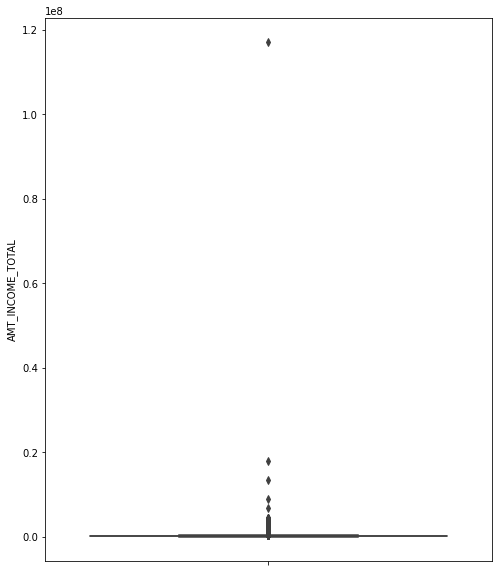

In [90]:
plt.figure(figsize=(8,10))
sns.boxplot(y="AMT_INCOME_TOTAL",data=Amt_numerical_data)

We try to drop Amt numerical_data which AMT_INCOME_TOTAL more than 10**6 to visualization clearfully.

In [91]:
Amt_drop_outlier = Amt_numerical_data.copy()
Amt_drop_outlier.loc[Amt_drop_outlier["AMT_INCOME_TOTAL"]>=0.1e+07	,"AMT_INCOME_TOTAL"] = np.nan
Amt_drop_outlier = Amt_drop_outlier.fillna(167180.897131)

In [92]:
Amt_numerical_type1 = Amt_drop_outlier[Amt_numerical_data.TARGET ==0]
Amt_numerical_type2 = Amt_drop_outlier[Amt_numerical_data.TARGET ==1]

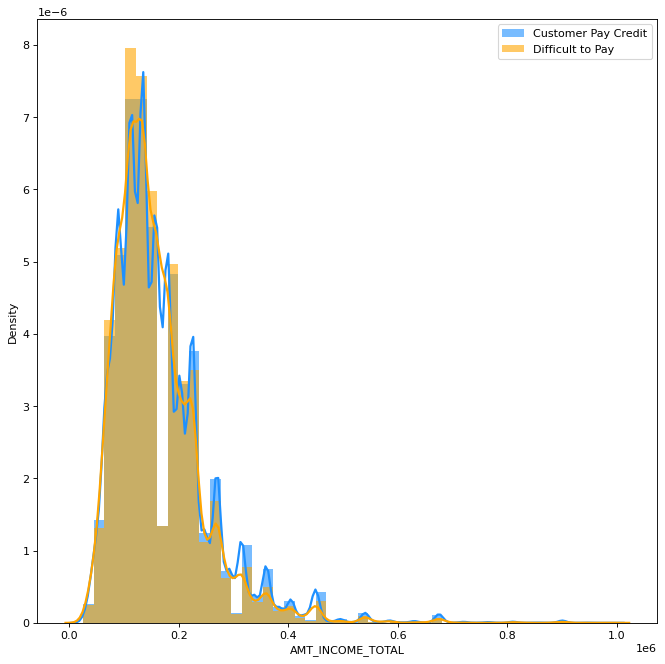

In [93]:
create_histogram(Amt_numerical_type1.columns[3])

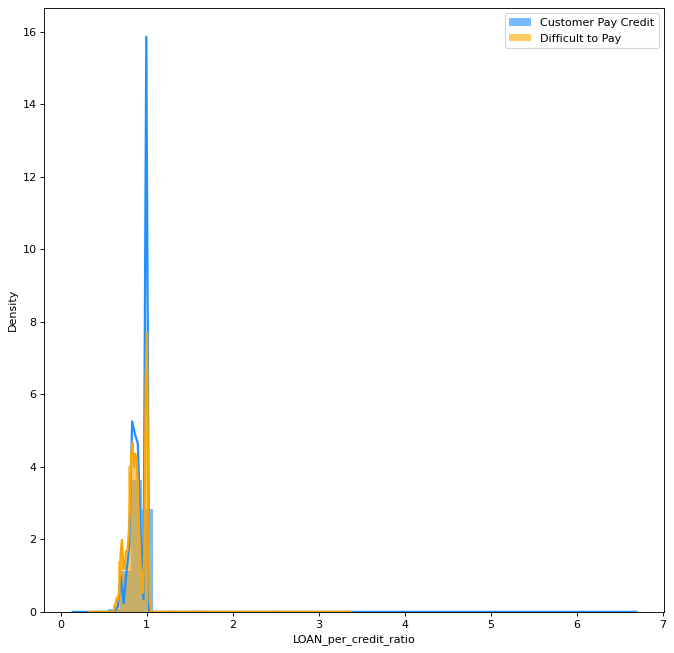

In [94]:
create_histogram(Amt_numerical_type1.columns[4])

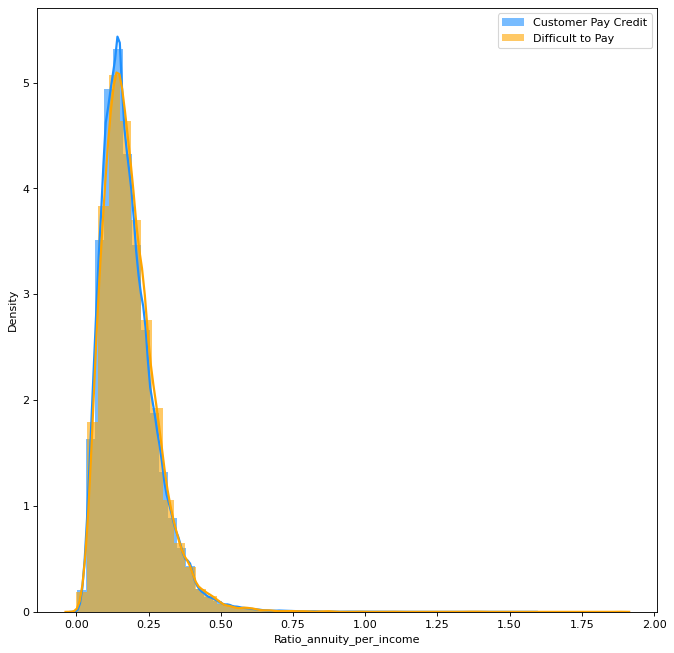

In [95]:
create_histogram(Amt_numerical_type1.columns[5])

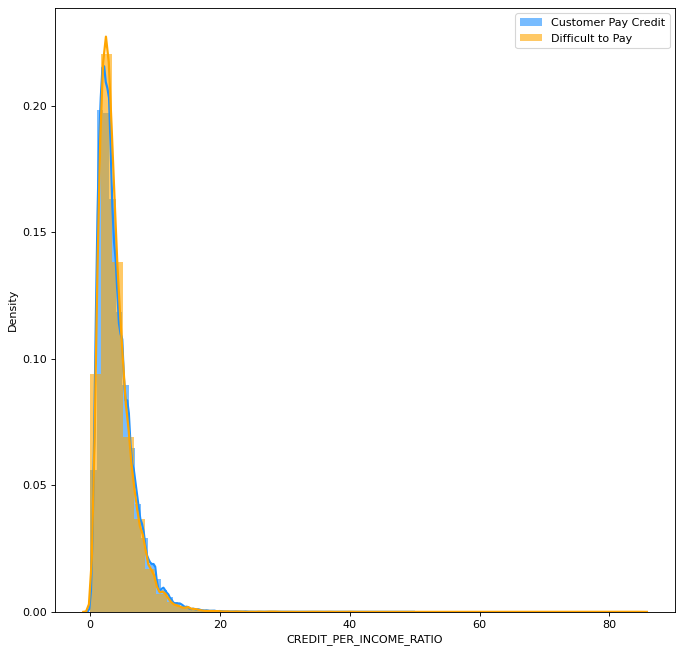

In [96]:
create_histogram(Amt_numerical_type1.columns[6])

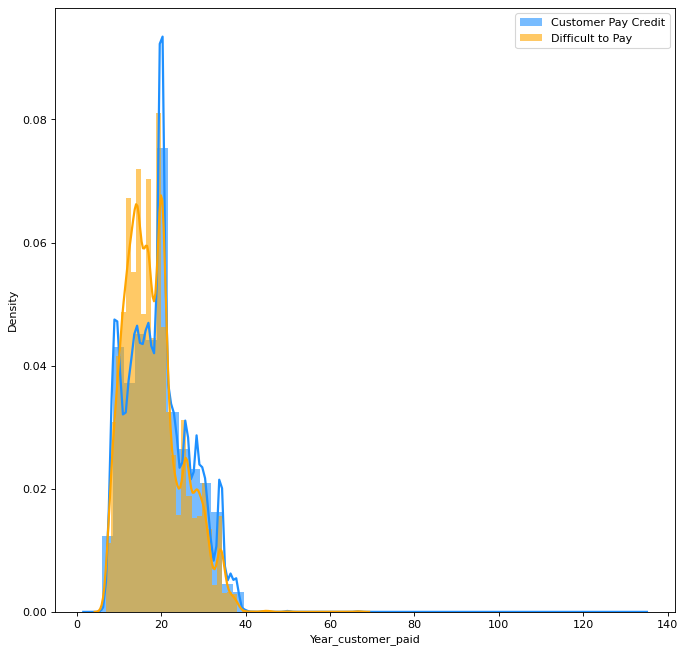

In [97]:
create_histogram(Amt_numerical_type1.columns[7])

Year customer paid when the customers are difficult to pay is lower than year customer pay credit.

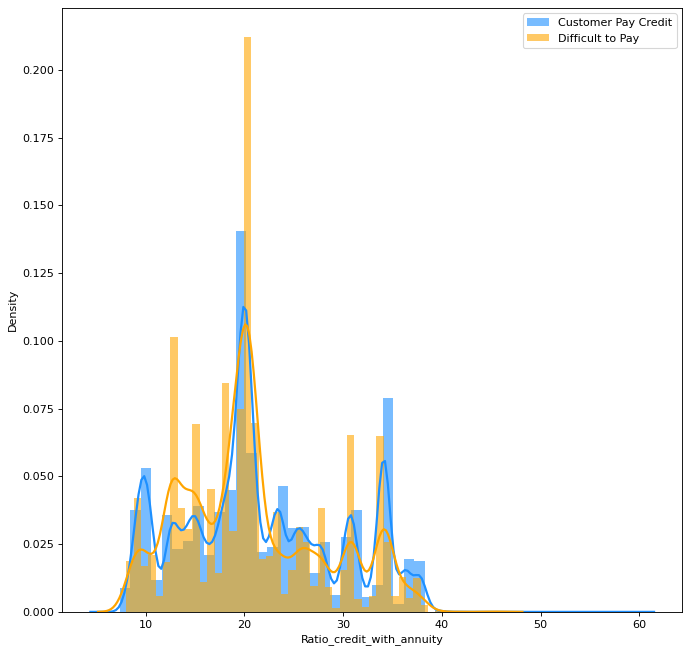

In [98]:
create_histogram(Amt_numerical_type1.columns[8])

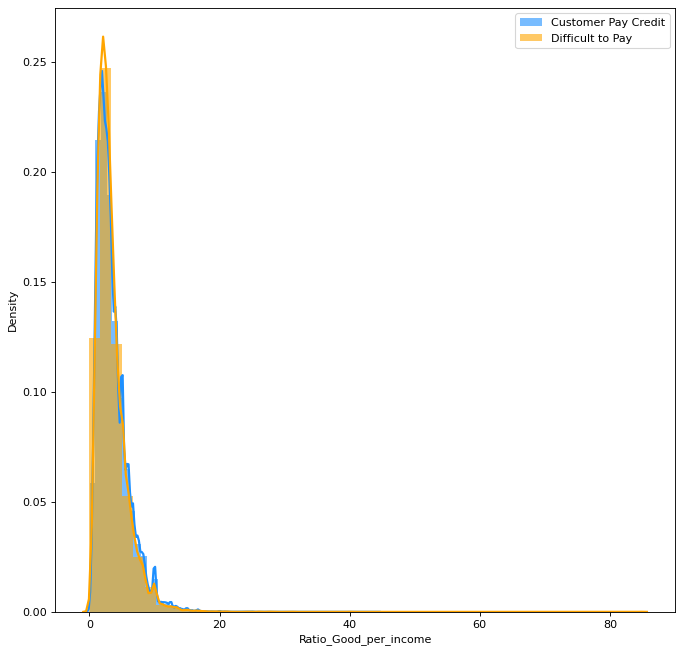

In [99]:
create_histogram(Amt_numerical_type1.columns[9])

<h3>Other data's column are the same distribution which two case because of imbalance data.

Next we will visualize age data

<h4>Drop the columns which flag documents is all the same in test data.

In [100]:
new_test_data = Test_data[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]


In [101]:
new_test_data.describe()

FLAG_DOCUMENT_2  FLAG_DOCUMENT_10  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  \
count          48744.0           48744.0           48744.0           48744.0   
mean               0.0               0.0               0.0               0.0   
std                0.0               0.0               0.0               0.0   
min                0.0               0.0               0.0               0.0   
25%                0.0               0.0               0.0               0.0   
50%                0.0               0.0               0.0               0.0   
75%                0.0               0.0               0.0               0.0   
max                0.0               0.0               0.0               0.0   

       FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
count           48744.0           48744.0           48744.0           48744.0   
mean                0.0               0.0               0.0               0.0   
std                 0.0               0.0               0.0               0.0   
min                 0.0               0.0               0.0               0.0   
25%                 0.0               0.0               0.0               0.0   
50%                 0.0               0.0               0.0               0.0   
75%                 0.0               0.0               0.0               0.0   
max                 0.0               0.0               0.0               0.0   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
count           48744.0           48744.0           48744.0  
mean                0.0               0.0               0.0  
std                 0.0               0.0               0.0  
min                 0.0               0.0               0.0  
25%                 0.0               0.0               0.0  
50%                 0.0               0.0               0.0  
75%                 0.0               0.0               0.0  
max                 0.0               0.0               0.0

We found that flag document in new_test_data columns in test data have the same so we drop columns in new_test_data 

In [102]:
columns_drop = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

Train_data.drop(columns=columns_drop,inplace=True)
Test_data.drop(columns=columns_drop,inplace=True)

<h4>Dealing with DAYS- columns

In [103]:
columns = ["DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION","DAYS_ID_PUBLISH","DAYS_LAST_PHONE_CHANGE"]
DAYS_data_train = Train_data[columns]
DAYS_data_test = Test_data[columns]

In [104]:
columns_year = []
for i in columns:
  columns_year.append(i.replace("DAYS","YEAR"))

In [105]:
def create_histogram(column_name,df_0,df_1):
    x1 = df_0[column_name]
    x2 = df_1[column_name]
        
    kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

    plt.figure(figsize=(10,10), dpi= 80)

    sns.distplot(x1, color="dodgerblue", label="Customer Pay Credit", **kwargs)
    sns.distplot(x2, color="orange", label="Difficult to Pay", **kwargs)
    plt.legend();
    

<h4>Change day's columns to year's columns.

In [106]:
YEARS_data_train = DAYS_data_train/365
YEARS_data_test = DAYS_data_test/365

In [107]:
YEARS_data_train["TARGET"] = Application_train["TARGET"]
YEARS_data_train

DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0        25.920548       1.745205           9.994521         5.808219   
1        45.931507       3.254795           3.249315         0.797260   
2        52.180822       0.616438          11.671233         6.934247   
3        52.068493       8.326027          26.939726         6.676712   
4        54.608219       8.323288          11.810959         9.473973   
...            ...            ...                ...              ...   
307506   25.553425       0.646575          23.167123         5.430137   
307507   56.917808       4.515068          12.021918        11.205479   
307508   41.002740      21.701370          18.457534        14.109589   
307509   32.769863      13.112329           7.019178         2.550685   
307510   46.180822       3.457534          14.049315         1.123288   

        DAYS_LAST_PHONE_CHANGE  TARGET  
0                     3.106849     1.0  
1                     2.268493     0.0  
2                     2.232877     0.0  
3                     1.690411     0.0  
4                     3.030137     0.0  
...                        ...     ...  
307506                0.747945     0.0  
307507                0.000000     0.0  
307508                5.230137     0.0  
307509                0.882192     1.0  
307510                2.156164     0.0  

[307511 rows x 6 columns]

In [108]:
YEARS_data_test

DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0       52.715068       6.380822          14.164384         2.224658   
1       49.490411      12.243836          24.980822         4.446575   
2       54.898630      12.213699           5.958904         9.597260   
3       38.290411       5.112329           5.479452        11.528767   
4       35.726027       6.002740          10.958904        11.676712   
...           ...            ...                ...              ...   
48739   54.712329      14.161644          24.915068         9.312329   
48740   30.646575       3.147945           8.260274         8.227397   
48741   43.621918       8.320548           7.345205         4.120548   
48742   38.268493       7.482192           4.002740         3.736986   
48743   38.252055       1.734247           2.936986        11.561644   

       DAYS_LAST_PHONE_CHANGE  
0                    4.767123  
1                    0.000000  
2                    2.345205  
3                    4.945205  
4                    2.249315  
...                       ...  
48739                1.873973  
48740                0.000000  
48741                2.295890  
48742                6.323288  
48743                0.895890  

[48744 rows x 5 columns]

In [109]:
dict_change = {}
for i in range(len(columns)):
  dict_change[columns[i]] = columns_year[i]
dict_change

{'DAYS_BIRTH': 'YEAR_BIRTH',
 'DAYS_EMPLOYED': 'YEAR_EMPLOYED',
 'DAYS_REGISTRATION': 'YEAR_REGISTRATION',
 'DAYS_ID_PUBLISH': 'YEAR_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE': 'YEAR_LAST_PHONE_CHANGE'}

In [110]:
YEARS_data_train.rename(columns=dict_change,inplace=True)
YEARS_data_test.rename(columns=dict_change,inplace=True)
YEARS_data_train=YEARS_data_train.apply(lambda x:abs(x))
YEARS_data_test=YEARS_data_test.apply(lambda x:abs(x))

<h4>Doing more with feature engineering with ratio employ and do label encoding with age category.

In [111]:
YEARS_data_train["AGE_CATEGORY"] = pd.cut(YEARS_data_train["YEAR_BIRTH"],bins = np.linspace(20,70,num = 11),include_lowest=True)
YEARS_data_test["AGE_CATEGORY"] = pd.cut(YEARS_data_test["YEAR_BIRTH"],bins = np.linspace(20,70,num = 11),include_lowest=True)

In [112]:
YEARS_data_train["RATIO_EMPLOY"] = YEARS_data_train["YEAR_EMPLOYED"]/YEARS_data_train["YEAR_BIRTH"]
YEARS_data_test["RATIO_EMPLOY"] = YEARS_data_test["YEAR_EMPLOYED"]/YEARS_data_test["YEAR_BIRTH"]

In [113]:
train_year = pd.get_dummies(YEARS_data_train)
test_year = pd.get_dummies(YEARS_data_test)

In [114]:
Train_data.drop(columns=columns,inplace=True)
Test_data.drop(columns=columns,inplace=True)

In [115]:
Train_data = pd.concat([Train_data,train_year],axis=1)
Test_data = pd.concat([Test_data,test_year],axis=1)

<h4>Doing visualization with Age data

In [116]:
df_0 = YEARS_data_train[YEARS_data_train["TARGET"]==0]
df_1 = YEARS_data_train[YEARS_data_train["TARGET"]==1]

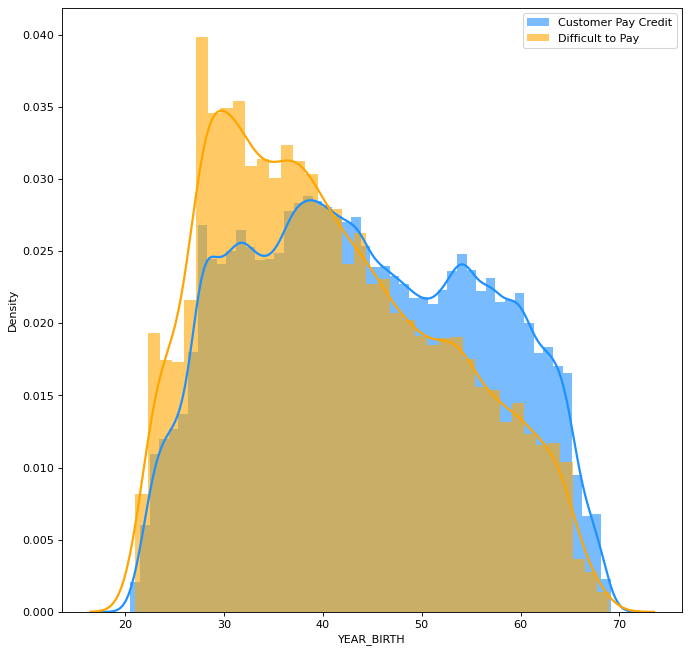

In [117]:
create_histogram(YEARS_data_train.columns[0],df_0,df_1)

<h4>We found that The less year birth the more difficult to pay the debt.

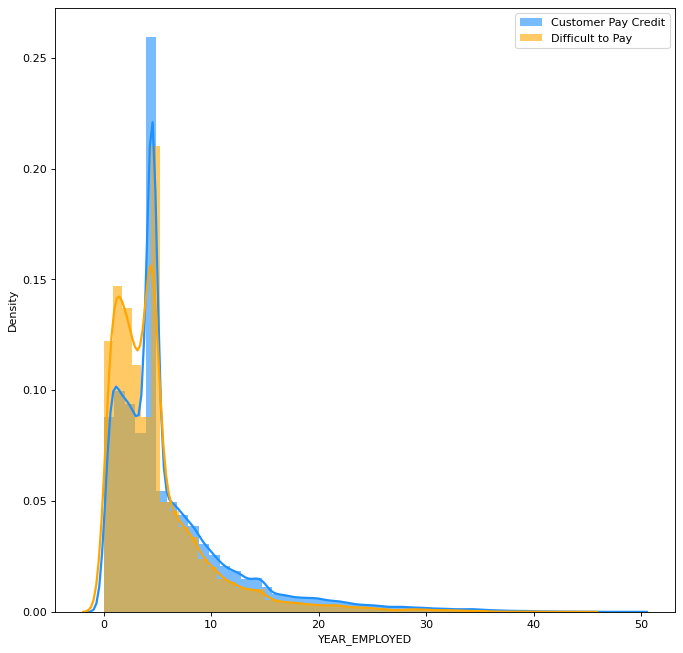

In [118]:
create_histogram(YEARS_data_train.columns[1],df_0,df_1)

<h4>We found that The less year employed the more difficult to pay the debt.

In [119]:
YEARS_data_train["TARGET"] = Application_train["TARGET"]

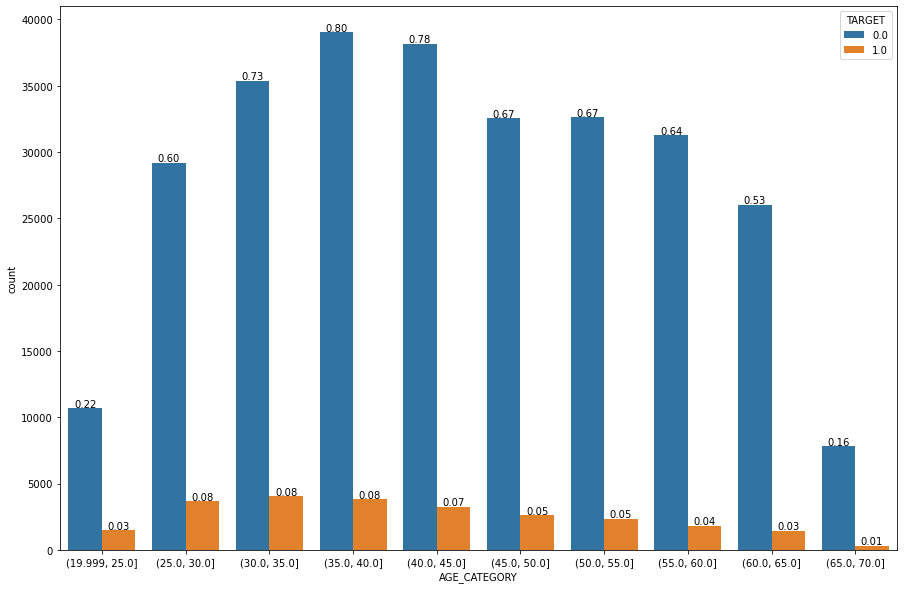

In [120]:
plt.figure(figsize=(15,10))
axes = sns.countplot(hue="TARGET",x="AGE_CATEGORY",data=YEARS_data_train)
total = float(Application_test.shape[0])
for p in axes.patches:
        height = p.get_height()
        axes.text(p.get_x()+p.get_width()/2,height+100,
            '{:1.2f}'.format(float(height/total)),
            ha="center") 
plt.show()

<h4>Age_category data confirm the previous inference in DAYS_BIRTH.

In [121]:
YEARS_data_train.drop(columns="TARGET",inplace=True)

Find the histogram with EXT_SCORE1,EXT_SCORE2,EXT_SCORE3 and YEAR_BIRTH

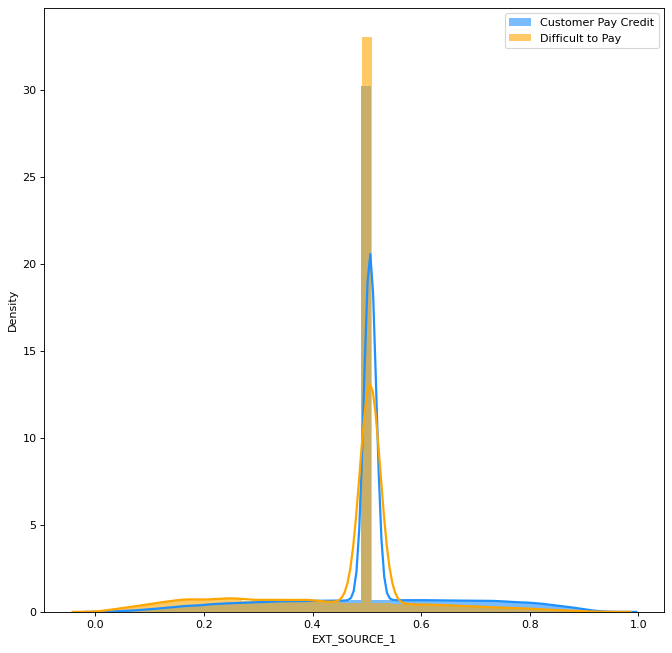

In [122]:
EXT_SCORE_viz = Train_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]]  
EXT_SCORE_viz["TARGET"] = Application_train["TARGET"]

df_0 = EXT_SCORE_viz[EXT_SCORE_viz["TARGET"] == 0]
df_1 = EXT_SCORE_viz[EXT_SCORE_viz["TARGET"] == 1]
x1 = df_0["EXT_SOURCE_1"]
x2 = df_1["EXT_SOURCE_1"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Customer Pay Credit", **kwargs)
sns.distplot(x2, color="orange", label="Difficult to Pay", **kwargs)
plt.legend();
    

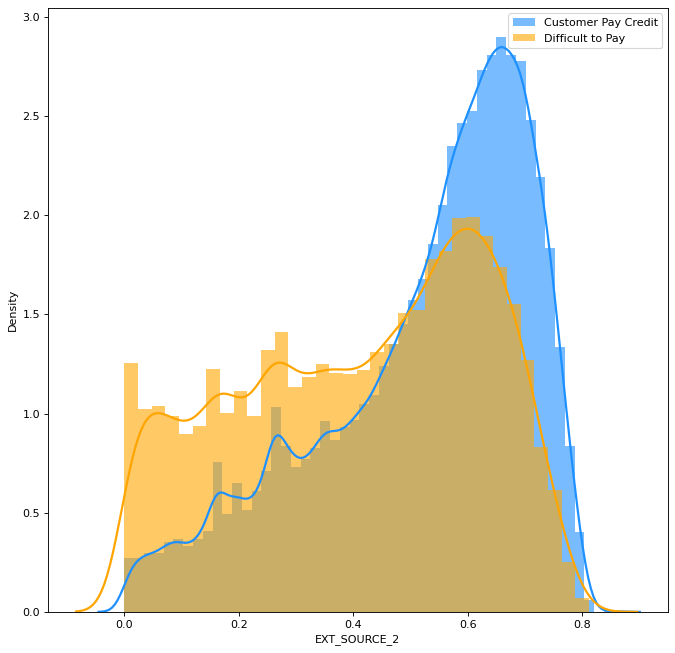

In [123]:
df_0 = EXT_SCORE_viz[EXT_SCORE_viz["TARGET"] == 0]
df_1 = EXT_SCORE_viz[EXT_SCORE_viz["TARGET"] == 1]
x1 = df_0["EXT_SOURCE_2"]
x2 = df_1["EXT_SOURCE_2"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Customer Pay Credit", **kwargs)
sns.distplot(x2, color="orange", label="Difficult to Pay", **kwargs)
plt.legend();
    

When customers are difficult to pay the ext source 2 are lower than customers who pay credit.

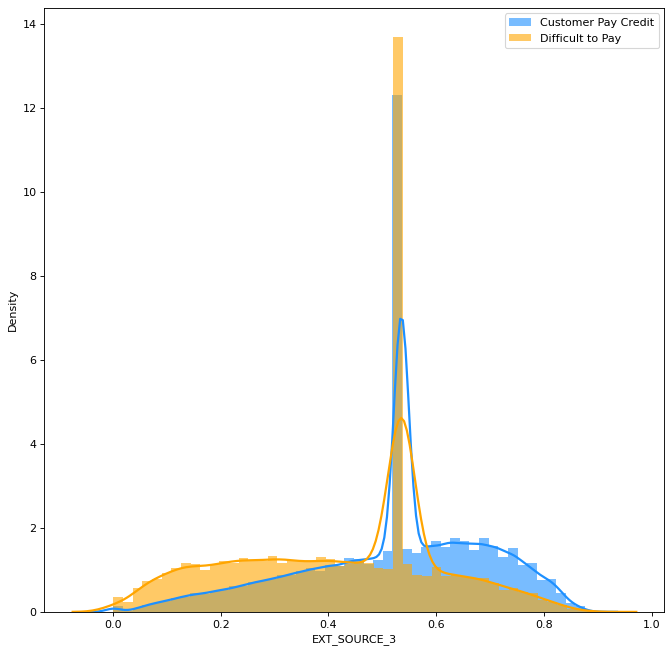

In [124]:
df_0 = EXT_SCORE_viz[EXT_SCORE_viz["TARGET"] == 0]
df_1 = EXT_SCORE_viz[EXT_SCORE_viz["TARGET"] == 1]
x1 = df_0["EXT_SOURCE_3"]
x2 = df_1["EXT_SOURCE_3"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Customer Pay Credit", **kwargs)
sns.distplot(x2, color="orange", label="Difficult to Pay", **kwargs)
plt.legend();

When customers are difficult to pay the ext source 3 are lower than customers who pay credit.

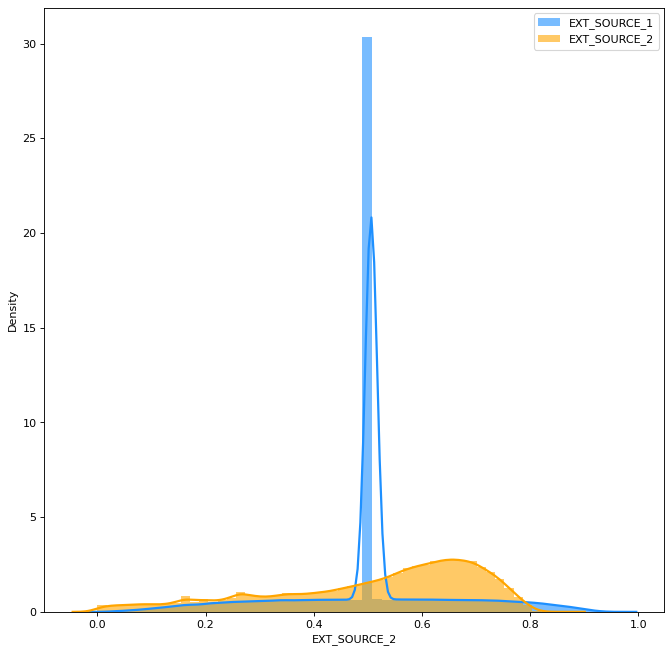

In [125]:
x1 = EXT_SCORE_viz["EXT_SOURCE_1"]
x2 = EXT_SCORE_viz["EXT_SOURCE_2"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="EXT_SOURCE_1", **kwargs)
sns.distplot(x2, color="orange", label="EXT_SOURCE_2", **kwargs)
plt.legend();

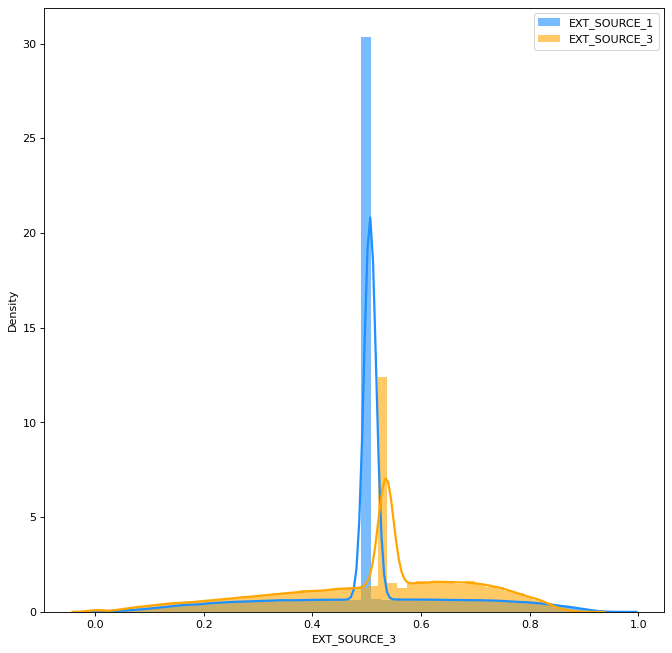

In [126]:
x1 = EXT_SCORE_viz["EXT_SOURCE_1"]
x2 = EXT_SCORE_viz["EXT_SOURCE_3"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="EXT_SOURCE_1", **kwargs)
sns.distplot(x2, color="orange", label="EXT_SOURCE_3", **kwargs)
plt.legend();

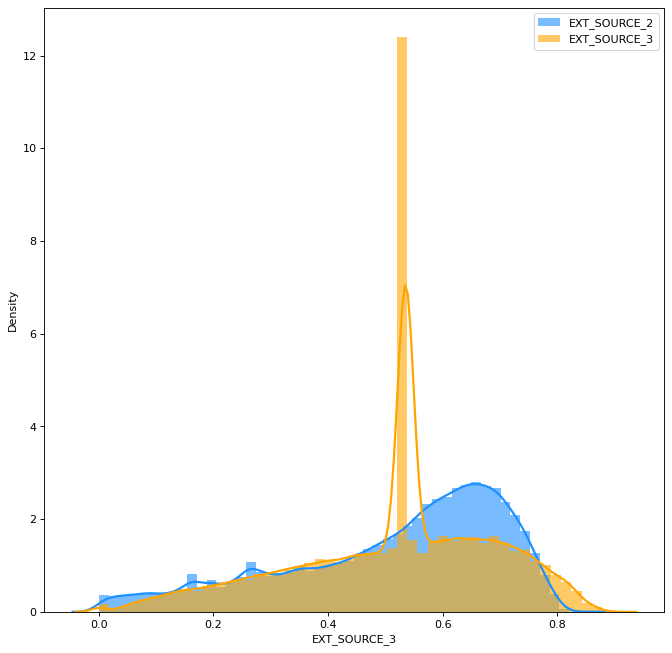

In [127]:
x1 = EXT_SCORE_viz["EXT_SOURCE_2"]
x2 = EXT_SCORE_viz["EXT_SOURCE_3"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="EXT_SOURCE_2", **kwargs)
sns.distplot(x2, color="orange", label="EXT_SOURCE_3", **kwargs)
plt.legend();

We need to normalize data to visualize better

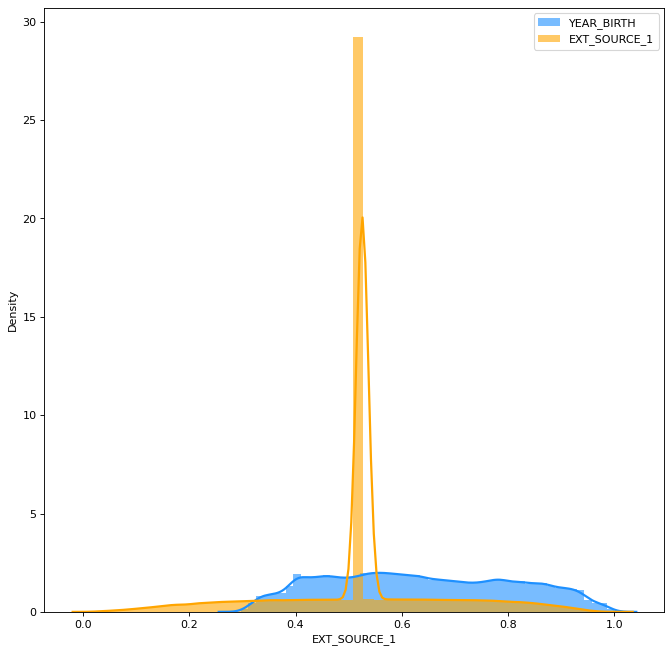

In [128]:
EXT_SCORE_viz2 = EXT_SCORE_viz/EXT_SCORE_viz.max()
x1 = EXT_SCORE_viz2["YEAR_BIRTH"]
x2 = EXT_SCORE_viz2["EXT_SOURCE_1"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="YEAR_BIRTH", **kwargs)
sns.distplot(x2, color="orange", label="EXT_SOURCE_1", **kwargs)
plt.legend();

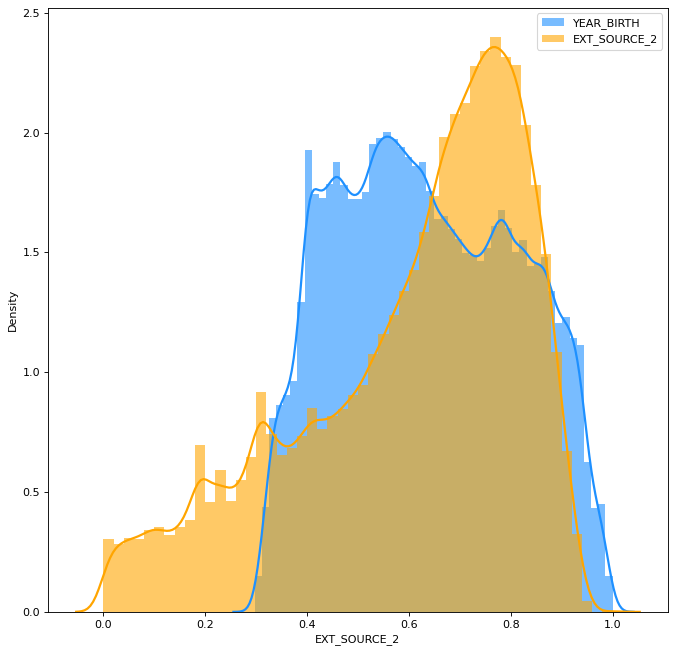

In [129]:
EXT_SCORE_viz2 = EXT_SCORE_viz/EXT_SCORE_viz.max()
x1 = EXT_SCORE_viz2["YEAR_BIRTH"]
x2 = EXT_SCORE_viz2["EXT_SOURCE_2"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="YEAR_BIRTH", **kwargs)
sns.distplot(x2, color="orange", label="EXT_SOURCE_2", **kwargs)
plt.legend();

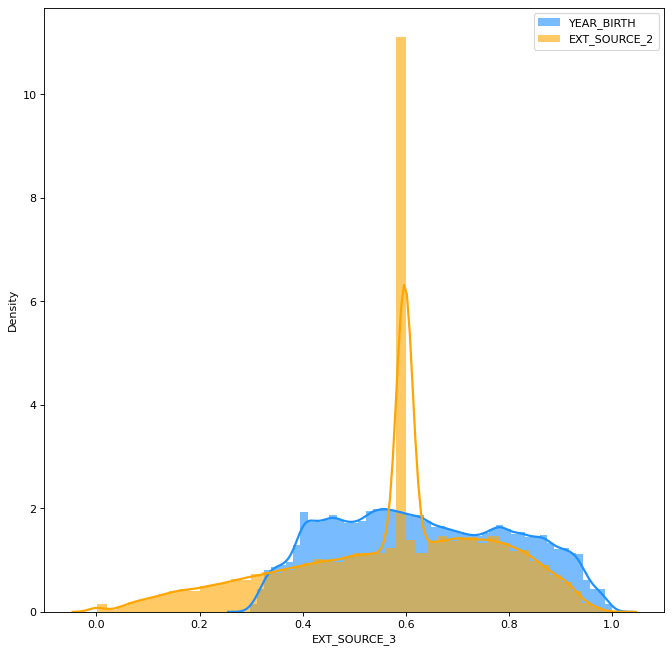

In [130]:
EXT_SCORE_viz2 = EXT_SCORE_viz/EXT_SCORE_viz.max()
x1 = EXT_SCORE_viz2["YEAR_BIRTH"]
x2 = EXT_SCORE_viz2["EXT_SOURCE_3"]
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="YEAR_BIRTH", **kwargs)
sns.distplot(x2, color="orange", label="EXT_SOURCE_2", **kwargs)
plt.legend();

Interesting correlation with YEAR_BIRTH and EXT_SOURCE

<h4>DO Polynomial feature with EXT_SOURCE and YEAR_BIRTH

In [131]:
from sklearn.preprocessing import PolynomialFeatures
EXT_SCORE = Train_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]]                              
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(EXT_SCORE)


PolynomialFeatures(degree=3)

In [132]:
train_ext_score = poly_transformer.fit_transform(EXT_SCORE)
test_ext_score = poly_transformer.fit_transform(Test_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]])

In [133]:
train_ext_score = pd.DataFrame(train_ext_score,columns=poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]))
test_ext_score= pd.DataFrame(test_ext_score,columns=poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]))

In [134]:
test_ext_score.drop(columns="1",inplace=True)
train_ext_score.drop(columns="1",inplace=True)

In [135]:
Train_data.drop(columns=EXT_SCORE.columns,inplace=True)
Test_data.drop(columns=EXT_SCORE.columns,inplace=True)

In [136]:
Train_data = pd.concat([Train_data,train_ext_score],axis=1)
Test_data = pd.concat([Test_data,test_ext_score],axis=1)

In [137]:
want_col = Application_train.select_dtypes(numerics).columns[32:75]
want_col

Index(['BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE'],
     

In [138]:
df_train = Train_data[want_col]
df_test = Test_data[want_col]

<h4>Feature engineering with Year_multiply ,RATIO_ELEVATORS_per_Floor, TOTAL_SCORE, and FLOOR_multiply

In [139]:
df_train["Year_multiply"] =df_train["YEARS_BEGINEXPLUATATION_MODE"]*df_train["YEARS_BEGINEXPLUATATION_MEDI"]*df_train["YEARS_BEGINEXPLUATATION_AVG"]
df_test["Year_multiply"] = df_test["YEARS_BEGINEXPLUATATION_MODE"]*df_test["YEARS_BEGINEXPLUATATION_MEDI"]*df_test["YEARS_BEGINEXPLUATATION_AVG"]

df_train["RATIO_ELEVATORS_per_Floor"] = df_train["ELEVATORS_MODE"]/df_train["FLOORSMAX_MODE"]
df_test["RATIO_ELEVATORS_per_Floor"] = df_test["ELEVATORS_MODE"]/df_test["FLOORSMAX_MODE"]

df_train["TOTAL_SCORE"] = Train_data[want_col].sum(axis=1)
df_test["TOTAL_SCORE"] = Test_data[want_col].sum(axis=1)

df_train["FLOOR_multiply"] = df_train["FLOORSMAX_AVG"]*df_train["ELEVATORS_AVG"]
df_test["FLOOR_multiply"] = df_test["FLOORSMAX_AVG"]*df_test["ELEVATORS_AVG"]

In [140]:
df_train["TARGET"] = Y_train

In [141]:
Train_data.drop(columns=want_col,inplace=True)
Test_data.drop(columns=want_col,inplace=True)

In [142]:
Train_data = pd.concat([Train_data,df_train],axis=1)
Test_data = pd.concat([Test_data,df_test],axis=1)

In [143]:
Train_data.drop(columns="TARGET",inplace=True)

In [144]:
Train_data["TARGET"] = Application_train["TARGET"]

In [145]:
Test_data.columns[180:]

Index(['CREDIT_PER_INCOME_RATIO', 'Year_customer_paid',
       'Ratio_credit_with_annuity', 'Ratio_Good_per_income', 'YEAR_EMPLOYED',
       'YEAR_REGISTRATION', 'YEAR_ID_PUBLISH', 'YEAR_LAST_PHONE_CHANGE',
       'RATIO_EMPLOY', 'AGE_CATEGORY_(19.999, 25.0]',
       'AGE_CATEGORY_(25.0, 30.0]', 'AGE_CATEGORY_(30.0, 35.0]',
       'AGE_CATEGORY_(35.0, 40.0]', 'AGE_CATEGORY_(40.0, 45.0]',
       'AGE_CATEGORY_(45.0, 50.0]', 'AGE_CATEGORY_(50.0, 55.0]',
       'AGE_CATEGORY_(55.0, 60.0]', 'AGE_CATEGORY_(60.0, 65.0]',
       'AGE_CATEGORY_(65.0, 70.0]', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEAR_BIRTH', 'EXT_SOURCE_1^2',
       'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3',
       'EXT_SOURCE_1 YEAR_BIRTH', 'EXT_SOURCE_2^2',
       'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 YEAR_BIRTH',
       'EXT_SOURCE_3^2', 'EXT_SOURCE_3 YEAR_BIRTH', 'YEAR_BIRTH^2',
       'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2',
       'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1^

<h2>Finish Application train and Application test and Feature engineering with Application train and Application test.

<h2>Next we will do all of the other dataframes.

In [146]:
def agg_numeric(dataframe,group_var,df_name):
  df_statistic = dataframe.groupby(group_var, as_index = False).agg(
      ['count', 'mean', 'max', 'min', 'sum']).reset_index()
  
  columns = [group_var]

  # Iterate through the variables names
  for col in df_statistic.columns.levels[0]:
    if col != group_var:
        # Iterate through the stat names
        for stat in df_statistic.columns.levels[1][:len(df_statistic.columns.levels[1])-1]:
            # Make a new column name for the variable and stat
            columns.append("%s_%s_%s" % (df_name,col, stat))  
  df_statistic.columns = columns
  return df_statistic
  
def agg_category(dataframe,group_var):
  Dummy_encoder = pd.get_dummies(dataframe)
  Categorical_data_from_bereau = Dummy_encoder.groupby(group_var).agg("sum")
  Categorical_data_from_bereau.reset_index(inplace=True)
  return Categorical_data_from_bereau

Check missing value percentage

In [147]:
def missing_value_percentage(dataframe):
    missing_percentage = dataframe.isnull().sum()/dataframe.shape[0] * 100
    missing_percentage_df = pd.DataFrame(missing_percentage,columns = ["Percentage missing values"])
    missing_percentage_df.sort_values(by="Percentage missing values",ascending=False,inplace=True)
    missing_percentage_df["Missing_values"] = dataframe.isnull().sum()
    return missing_percentage_df
    

In [148]:
missing_value_percentage(POS_CASH_balance)

Percentage missing values  Missing_values
CNT_INSTALMENT_FUTURE                   0.260835           26087
CNT_INSTALMENT                          0.260675           26071
SK_ID_PREV                              0.000000               0
SK_ID_CURR                              0.000000               0
MONTHS_BALANCE                          0.000000               0
NAME_CONTRACT_STATUS                    0.000000               0
SK_DPD                                  0.000000               0
SK_DPD_DEF                              0.000000               0

Missing a little data so we don't fill anything

<h4>We use agg_numeric function to do feature engineering with numerical data and agg_category function to do feature engineering with categorical data.

In [149]:
POS_numeric = POS_CASH_balance.select_dtypes(["int64","float64"])
POS_category = POS_CASH_balance.select_dtypes("object")

In [150]:
POS_category["SK_ID_PREV"] = POS_CASH_balance["SK_ID_PREV"]
POS_category["SK_ID_CURR"] = POS_CASH_balance["SK_ID_CURR"]

In [151]:
POS_numeric.drop(columns="SK_ID_CURR",axis=1,inplace=True)

<h4>Visualize numerical data and categorical data.

In [152]:
POS_category

NAME_CONTRACT_STATUS  SK_ID_PREV  SK_ID_CURR
0                      Active     1803195      182943
1                      Active     1715348      367990
2                      Active     1784872      397406
3                      Active     1903291      269225
4                      Active     2341044      334279
...                       ...         ...         ...
10001353               Active     2448283      226558
10001354               Active     1717234      141565
10001355               Active     1283126      315695
10001356               Active     1082516      450255
10001357            Completed     1259607      174278

[10001358 rows x 3 columns]

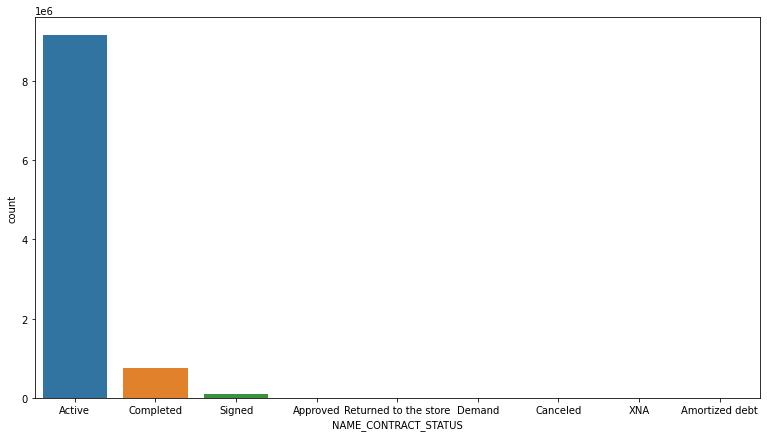

In [153]:
plt.figure(figsize=(13,7))
categorical_viz = POS_category[["NAME_CONTRACT_STATUS"]]
sns.countplot(x="NAME_CONTRACT_STATUS",data=categorical_viz)
plt.show()

In [154]:
POS_numeric

SK_ID_PREV  MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE  \
0            1803195             -31            48.0                   45.0   
1            1715348             -33            36.0                   35.0   
2            1784872             -32            12.0                    9.0   
3            1903291             -35            48.0                   42.0   
4            2341044             -35            36.0                   35.0   
...              ...             ...             ...                    ...   
10001353     2448283             -20             6.0                    0.0   
10001354     1717234             -19            12.0                    0.0   
10001355     1283126             -21            10.0                    0.0   
10001356     1082516             -22            12.0                    0.0   
10001357     1259607             -52            16.0                    0.0   

          SK_DPD  SK_DPD_DEF  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0  
...          ...         ...  
10001353     843           0  
10001354     602           0  
10001355     609           0  
10001356     614           0  
10001357       0           0  

[10001358 rows x 6 columns]

In [155]:
POS_numeric["YEAR_SK_DPD"] = POS_numeric["SK_DPD"]/365
POS_numeric["YEAR_SK_DPD_DEF"] = POS_numeric["SK_DPD_DEF"]/365

In [156]:
POS_data_numeric = agg_numeric(POS_numeric,"SK_ID_PREV","POS_numeric")
POS_data_category = agg_category(POS_category,"SK_ID_PREV")

In [157]:
POS_data_numeric

SK_ID_PREV  POS_numeric_MONTHS_BALANCE_count  \
0          1000001                                 3   
1          1000002                                 5   
2          1000003                                 4   
3          1000004                                 8   
4          1000005                                11   
...            ...                               ...   
936320     2843494                                 3   
936321     2843495                                 8   
936322     2843497                                21   
936323     2843498                                 7   
936324     2843499                                11   

        POS_numeric_MONTHS_BALANCE_mean  POS_numeric_MONTHS_BALANCE_max  \
0                                  -9.0                              -8   
1                                 -52.0                             -50   
2                                  -2.5                              -1   
3                                 -25.5                             -22   
4                                 -51.0                             -46   
...                                 ...                             ...   
936320                            -25.0                             -24   
936321                            -12.5                              -9   
936322                            -11.0                              -1   
936323                            -45.0                             -42   
936324                            -35.0                             -30   

        POS_numeric_MONTHS_BALANCE_min  POS_numeric_MONTHS_BALANCE_sum  \
0                                  -10                             -27   
1                                  -54                            -260   
2                                   -4                             -10   
3                                  -29                            -204   
4                                  -56                            -561   
...                                ...                             ...   
936320                             -26                             -75   
936321                             -16                            -100   
936322                             -21                            -231   
936323                             -48                            -315   
936324                             -40                            -385   

        POS_numeric_CNT_INSTALMENT_count  POS_numeric_CNT_INSTALMENT_mean  \
0                                      3                         8.666667   
1                                      5                         5.200000   
2                                      4                        12.000000   
3                                      8                         9.625000   
4                                     11                        10.000000   
...                                  ...                              ...   
936320                                 3                        32.666667   
936321                                 8                        53.375000   
936322                                21                        24.000000   
936323                                 7                        27.428571   
936324                                11                        50.909091   

        POS_numeric_CNT_INSTALMENT_max  POS_numeric_CNT_INSTALMENT_min  ...  \
0                                 12.0                             2.0  ...   
1                                  6.0                             4.0  ...   
2                                 12.0                            12.0  ...   
3                                 10.0                             7.0  ...   
4                                 10.0                            10.0  ...   
...                                ...                             ...  ...   
936320                            48.0                             

<h4>We will plot histogram with POS_data_numeric

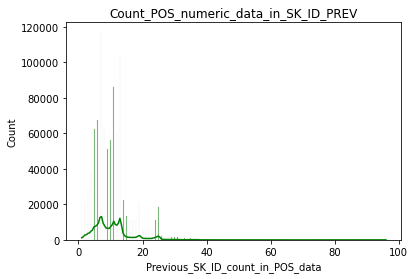

In [158]:
plt.title("Count_POS_numeric_data_in_SK_ID_PREV")
sns.histplot(POS_data_numeric.iloc[:,1],color="green",kde=True)
plt.xlabel("Previous_SK_ID_count_in_POS_data")
plt.show()

In [159]:
POS_data_numeric.columns

Index(['SK_ID_PREV', 'POS_numeric_MONTHS_BALANCE_count',
       'POS_numeric_MONTHS_BALANCE_mean', 'POS_numeric_MONTHS_BALANCE_max',
       'POS_numeric_MONTHS_BALANCE_min', 'POS_numeric_MONTHS_BALANCE_sum',
       'POS_numeric_CNT_INSTALMENT_count', 'POS_numeric_CNT_INSTALMENT_mean',
       'POS_numeric_CNT_INSTALMENT_max', 'POS_numeric_CNT_INSTALMENT_min',
       'POS_numeric_CNT_INSTALMENT_sum',
       'POS_numeric_CNT_INSTALMENT_FUTURE_count',
       'POS_numeric_CNT_INSTALMENT_FUTURE_mean',
       'POS_numeric_CNT_INSTALMENT_FUTURE_max',
       'POS_numeric_CNT_INSTALMENT_FUTURE_min',
       'POS_numeric_CNT_INSTALMENT_FUTURE_sum', 'POS_numeric_SK_DPD_count',
       'POS_numeric_SK_DPD_mean', 'POS_numeric_SK_DPD_max',
       'POS_numeric_SK_DPD_min', 'POS_numeric_SK_DPD_sum',
       'POS_numeric_SK_DPD_DEF_count', 'POS_numeric_SK_DPD_DEF_mean',
       'POS_numeric_SK_DPD_DEF_max', 'POS_numeric_SK_DPD_DEF_min',
       'POS_numeric_SK_DPD_DEF_sum', 'POS_numeric_YEAR_SK_DPD_count',
 

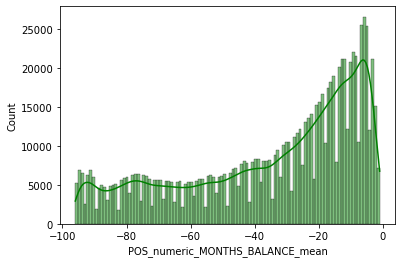

In [160]:
sns.histplot(POS_data_numeric['POS_numeric_MONTHS_BALANCE_mean'],color="green",kde=True)
plt.show()

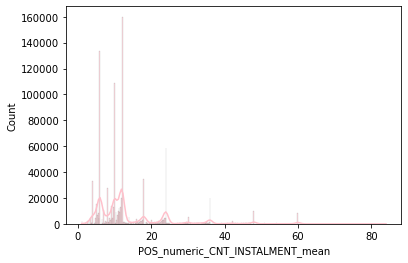

In [161]:
sns.histplot(POS_data_numeric["POS_numeric_CNT_INSTALMENT_mean"],color="pink",kde=True)
plt.show()

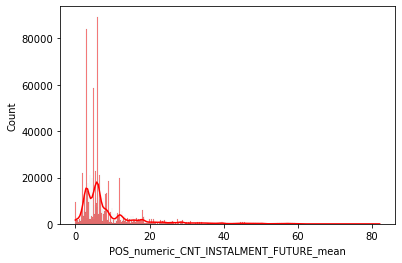

In [162]:
sns.histplot(POS_data_numeric['POS_numeric_CNT_INSTALMENT_FUTURE_mean'],color="red",kde=True)
plt.show()

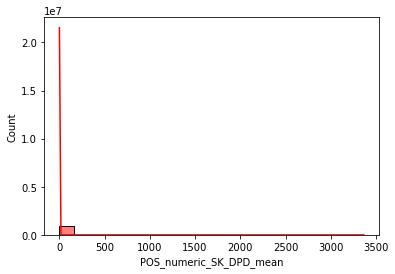

In [163]:
sns.histplot(POS_data_numeric['POS_numeric_SK_DPD_mean'],color="red",kde=True)
plt.show()

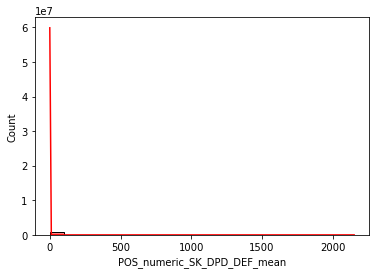

In [164]:
sns.histplot(POS_data_numeric['POS_numeric_SK_DPD_DEF_mean'],color="red",kde=True)
plt.show()

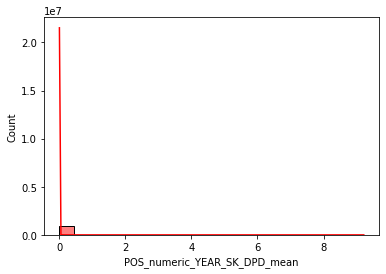

In [165]:
sns.histplot(POS_data_numeric["POS_numeric_YEAR_SK_DPD_mean"],color="red",kde=True)
plt.show()

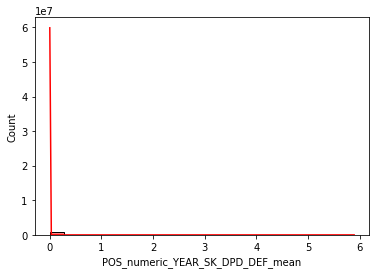

In [166]:
sns.histplot(POS_data_numeric["POS_numeric_YEAR_SK_DPD_DEF_mean"],color="red",kde=True)
plt.show()

In [167]:
SK_ID_Curr_pos = POS_CASH_balance.groupby("SK_ID_PREV")["SK_ID_CURR"].first().values

In [168]:
POS_data_transform = POS_data_numeric.merge(POS_data_category,on="SK_ID_PREV",how="left")

In [169]:
POS_data_transform["SK_ID_CURR"] = SK_ID_Curr_pos 

In [170]:
installment = Installments_payments.drop(columns="SK_ID_CURR").groupby("SK_ID_PREV", as_index = False).agg(
      ['count', 'mean', 'max', 'min', 'sum']).reset_index()
  
columns = ["SK_ID_PREV"]

for col in installment.columns.levels[0]:
  if col not in columns:
      for stat in installment.columns.levels[1][:-1]:
        columns.append("%s_%s_%s" % ("installment",col, stat))  
installment.columns = columns

In [171]:
installment["SK_ID_CURR"] = Installments_payments.groupby("SK_ID_PREV")["SK_ID_CURR"].first().values

In [172]:
missing_value_percentage(Installments_payments)

Percentage missing values  Missing_values
DAYS_ENTRY_PAYMENT                       0.021352            2905
AMT_PAYMENT                              0.021352            2905
SK_ID_PREV                               0.000000               0
SK_ID_CURR                               0.000000               0
NUM_INSTALMENT_VERSION                   0.000000               0
NUM_INSTALMENT_NUMBER                    0.000000               0
DAYS_INSTALMENT                          0.000000               0
AMT_INSTALMENT                           0.000000               0

A little bit of data we ignore it.

Visualize Instalments Data (All data is numerical datas.)

In [173]:
installment

SK_ID_PREV  installment_NUM_INSTALMENT_VERSION_count  \
0          1000001                                         2   
1          1000002                                         4   
2          1000003                                         3   
3          1000004                                         7   
4          1000005                                        11   
...            ...                                       ...   
997747     2843495                                         7   
997748     2843496                                        34   
997749     2843497                                        20   
997750     2843498                                         6   
997751     2843499                                        10   

        installment_NUM_INSTALMENT_VERSION_mean  \
0                                      1.500000   
1                                      1.250000   
2                                      1.000000   
3                                      1.142857   
4                                      1.000000   
...                                         ...   
997747                                 1.142857   
997748                                 0.000000   
997749                                 1.000000   
997750                                 1.333333   
997751                                 1.100000   

        installment_NUM_INSTALMENT_VERSION_max  \
0                                          2.0   
1                                          2.0   
2                                          1.0   
3                                          2.0   
4                                          1.0   
...                                        ...   
997747                                     2.0   
997748                                     0.0   
997749                                     1.0   
997750                                     3.0   
997751                                     2.0   

        installment_NUM_INSTALMENT_VERSION_min  \
0                                          1.0   
1                                          1.0   
2                                          1.0   
3                                          1.0   
4                                          1.0   
...                                        ...   
997747                                     1.0   
997748                                     0.0   
997749                                     1.0   
997750                                     1.0   
997751                                     1.0   

        installment_NUM_INSTALMENT_VERSION_sum  \
0                                          3.0   
1                                          5.0   
2                                          3.0   
3                                          8.0   
4                                         11.0   
...                                        ...   
997747                                     8.0   
997748                                     0.0   
997749                                    20.0   
997750                                     8.0   
997751                                    11.0   

        installment_NUM_INSTALMENT_NUMBER_count  \
0                                             2   
1                                             4   
2                                             3   
3                                             7   
4                                            11   
...                                         ...   
997747                                        7   
997748                                       34   
997749                                       20   
997750                                        6   
997751                                       10   

        installment_NUM_INSTALMENT_NUMBER_mean  \
0                                     1.500000   
1                                     2.500000   
2                                     2.000000   
3         

We want to do feature engineering or something with installment to make some interesting feature.

In [174]:
check_columns_only_mean = installment.columns
list_col = []
for col in check_columns_only_mean:
    if "mean" in col:
        list_col.append(col)
    elif "sum" in col:
        list_col.append(col)

In [175]:
feature_installment = installment[list_col]
feature_installment

installment_NUM_INSTALMENT_VERSION_mean  \
0                                      1.500000   
1                                      1.250000   
2                                      1.000000   
3                                      1.142857   
4                                      1.000000   
...                                         ...   
997747                                 1.142857   
997748                                 0.000000   
997749                                 1.000000   
997750                                 1.333333   
997751                                 1.100000   

        installment_NUM_INSTALMENT_VERSION_sum  \
0                                          3.0   
1                                          5.0   
2                                          3.0   
3                                          8.0   
4                                         11.0   
...                                        ...   
997747                                     8.0   
997748                                     0.0   
997749                                    20.0   
997750                                     8.0   
997751                                    11.0   

        installment_NUM_INSTALMENT_NUMBER_mean  \
0                                     1.500000   
1                                     2.500000   
2                                     2.000000   
3                                     4.000000   
4                                     5.818182   
...                                        ...   
997747                                4.000000   
997748                               16.235294   
997749                               10.500000   
997750                                3.500000   
997751                                5.500000   

        installment_NUM_INSTALMENT_NUMBER_sum  \
0                                           3   
1                                          10   
2                                           6   
3                                          28   
4                                          64   
...                                       ...   
997747                                     28   
997748                                    552   
997749                                    210   
997750                                     21   
997751                                     55   

        installment_DAYS_INSTALMENT_mean  installment_DAYS_INSTALMENT_sum  \
0                            -253.000000                           -506.0   
1                           -1555.000000                          -6220.0   
2                             -64.000000                           -192.0   
3                            -772.000000                          -5404.0   
4                           -1543.454545                         -16978.0   
...                                  ...                              ...   
997747                       -349.000000                          -2443.0   
997748                       -258.058824                          -8774.0   
997749                       -303.000000                          -6060.0   
997750                      -1367.666667                          -8206.0   
997751                      -1068.000000                         -10680.0   

        installment_DAYS_ENTRY_PAYMENT_mean  \
0                               -269.000000   
1                              -1574.750000   
2                                -79.333333   
3                               -798.714286   
4                              -1551.909091   
...                                     ...   
997747                          -352.857143   
997748                          -262.058824   
997749                          -305.900000   
997750                         -1380.333333   
997751                         -1091.100000   

        installment_DAYS_ENTRY_PAYMENT_sum  installment_AMT_INSTALMENT_mean  \
0                                  

In [176]:
feature_installment.describe()

installment_NUM_INSTALMENT_VERSION_mean  \
count                            997752.000000   
mean                                  1.119818   
std                                   0.688599   
min                                   0.000000   
25%                                   1.000000   
50%                                   1.000000   
75%                                   1.142857   
max                                  89.500000   

       installment_NUM_INSTALMENT_VERSION_sum  \
count                           997752.000000   
mean                                11.681153   
std                                 16.589139   
min                                  0.000000   
25%                                  6.000000   
50%                                  9.000000   
75%                                 13.000000   
max                               1802.000000   

       installment_NUM_INSTALMENT_NUMBER_mean  \
count                           997752.000000   
mean                                 7.289668   
std                                  9.228833   
min                                  1.000000   
25%                                  3.500000   
50%                                  5.500000   
75%                                  7.000000   
max                                183.657143   

       installment_NUM_INSTALMENT_NUMBER_sum  \
count                          997752.000000   
mean                              257.324571   
std                              1097.909983   
min                                 1.000000   
25%                                21.000000   
50%                                55.000000   
75%                                91.000000   
max                             43479.000000   

       installment_DAYS_INSTALMENT_mean  installment_DAYS_INSTALMENT_sum  \
count                     997752.000000                    997752.000000   
mean                       -1016.312317                    -14212.450775   
std                          818.555959                     25680.062635   
min                        -2922.000000                   -560740.000000   
25%                        -1588.186364                    -16500.000000   
50%                         -754.000000                     -7562.000000   
75%                         -327.000000                     -2652.000000   
max                           -2.000000                        -2.000000   

       installment_DAYS_ENTRY_PAYMENT_mean  \
count                        997674.000000   
mean                          -1027.906630   
std                             817.311118   
min                           -3071.000000   
25%                           -1600.750000   
50%                            -766.833333   
75%                            -339.272727   
max                              -2.000000   

       installment_DAYS_ENTRY_PAYMENT_sum  installment_AMT_INSTALMENT_mean  \
count                       997752.000000                     9.977520e+05   
mean                        -14329.983486                     2.565759e+04   
std                          25719.212417                     6.318139e+04   
min                        -562629.000000                     0.000000e+00   
25%                         -16632.000000                     6.441636e+03   
50%                          -7696.000000                     1.161217e+04   
75%                          -2755.000000                     2.280128e+04   
max                              0.000000                     3.202062e+06   

       installment_AMT_INSTALMENT_sum  installment_AMT_PAYMENT_mean  \
count                    9.977520e+05                  9.976740e+05   
mean                     2.325071e+05                  2.629144e+04   
std                      3.403746e+05                  6.555737e+04   
min                      0.000000e+00                  4.500000e-02   
25%                      5.375796e+04                  6.163566e+03   
50%       

There isn't an important feature in feature instalment data.

In [177]:
installment_transform = installment.copy()

<AxesSubplot:ylabel='Frequency'>

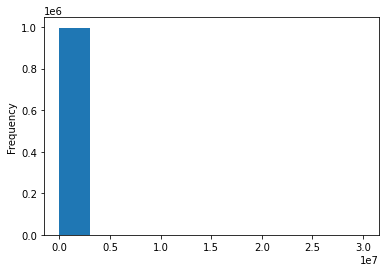

In [178]:
feature_installment.installment_AMT_PAYMENT_sum.plot.hist()

In [179]:
card_balance = pd.get_dummies(Credit_card_balance)


Check missing percentage values.

In [180]:
missing_value_percentage(card_balance)

Percentage missing values  Missing_values
AMT_PAYMENT_CURRENT                                 19.998063          767988
CNT_DRAWINGS_OTHER_CURRENT                          19.524872          749816
AMT_DRAWINGS_POS_CURRENT                            19.524872          749816
CNT_DRAWINGS_ATM_CURRENT                            19.524872          749816
AMT_DRAWINGS_ATM_CURRENT                            19.524872          749816
CNT_DRAWINGS_POS_CURRENT                            19.524872          749816
AMT_DRAWINGS_OTHER_CURRENT                          19.524872          749816
CNT_INSTALMENT_MATURE_CUM                            7.948208          305236
AMT_INST_MIN_REGULARITY                              7.948208          305236
NAME_CONTRACT_STATUS_Completed                       0.000000               0
NAME_CONTRACT_STATUS_Demand                          0.000000               0
NAME_CONTRACT_STATUS_Approved                        0.000000               0
NAME_CONTRACT_STATUS_Active                          0.000000               0
SK_DPD_DEF                                           0.000000               0
SK_DPD                                               0.000000               0
NAME_CONTRACT_STATUS_Refused                         0.000000               0
NAME_CONTRACT_STATUS_Sent proposal                   0.000000               0
SK_ID_PREV                                           0.000000               0
AMT_TOTAL_RECEIVABLE                                 0.000000               0
CNT_DRAWINGS_CURRENT                                 0.000000               0
SK_ID_CURR                                           0.000000               0
AMT_RECIVABLE                                        0.000000               0
AMT_RECEIVABLE_PRINCIPAL                             0.000000               0
AMT_PAYMENT_TOTAL_CURRENT                            0.000000               0
AMT_DRAWINGS_CURRENT                                 0.000000               0
AMT_CREDIT_LIMIT_ACTUAL                              0.000000               0
AMT_BALANCE                                          0.000000               0
MONTHS_BALANCE                                       0.000000               0
NAME_CONTRACT_STATUS_Signed                          0.000000               0

In [181]:
one_hot_encoder_data = card_balance.iloc[:,22:]
one_hot_encoder_data["SK_ID_PREV"] = card_balance["SK_ID_PREV"]
one_hot_encoder_data= one_hot_encoder_data.groupby("SK_ID_PREV").sum()
one_hot_encoder_data.reset_index(inplace=True)
card_balance1 = card_balance.iloc[:,:22]

In [182]:
card_balance1.drop(columns="SK_ID_CURR",inplace=True)

In [183]:
card_numerical_transform = agg_numeric(card_balance1,"SK_ID_PREV","CARD_BALANCE")

In [184]:
card_numerical_transform

SK_ID_PREV  CARD_BALANCE_MONTHS_BALANCE_count  \
0          1000018                                  5   
1          1000030                                  8   
2          1000031                                 16   
3          1000035                                  5   
4          1000077                                 11   
...            ...                                ...   
104302     2843476                                 95   
104303     2843477                                 85   
104304     2843478                                 90   
104305     2843493                                 15   
104306     2843496                                 15   

        CARD_BALANCE_MONTHS_BALANCE_mean  CARD_BALANCE_MONTHS_BALANCE_max  \
0                                   -4.0                               -2   
1                                   -4.5                               -1   
2                                   -8.5                               -1   
3                                   -4.0                               -2   
4                                   -7.0                               -2   
...                                  ...                              ...   
104302                             -49.0                               -2   
104303                             -43.0                               -1   
104304                             -46.5                               -2   
104305                              -8.0                               -1   
104306                              -8.0                               -1   

        CARD_BALANCE_MONTHS_BALANCE_min  CARD_BALANCE_MONTHS_BALANCE_sum  \
0                                    -6                              -20   
1                                    -8                              -36   
2                                   -16                             -136   
3                                    -6                              -20   
4                                   -12                              -77   
...                                 ...                              ...   
104302                              -96                            -4655   
104303                              -85                            -3655   
104304                              -91                            -4185   
104305                              -15                             -120   
104306                              -15                             -120   

        CARD_BALANCE_AMT_BALANCE_count  CARD_BALANCE_AMT_BALANCE_mean  \
0                                    5                   74946.285000   
1                                    8                   55991.064375   
2                                   16                   52394.439375   
3                                    5                       0.000000   
4                                   11                       0.000000   
...                                ...                            ...   
104302                              95                   37937.812263   
104303                              85                    1663.076647   
104304                              90                    5111.405000   
104305                              15                   59139.927000   
104306                              15                   44373.681000   

        CARD_BALANCE_AMT_BALANCE_max  CARD_BALANCE_AMT_BALANCE_min  ...  \
0                         136695.420                     38879.145  ...   
1                         103027.275                         0.000  ...   
2                         154945.935                         0.000  ...   
3                              0.000                         0.000  ...   
4                              0.000                         0.000  ...   
...                              ...                           ...  ...   
104302                    173458.800                         0.000  ...   
104303  

Try to do some more feature engineering in card numerical feature.

In [185]:
card_balance1

SK_ID_PREV  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
0           2562384              -6       56.970                   135000   
1           2582071              -1    63975.555                    45000   
2           1740877              -7    31815.225                   450000   
3           1389973              -4   236572.110                   225000   
4           1891521              -1   453919.455                   450000   
...             ...             ...          ...                      ...   
3840307     1036507              -9        0.000                    45000   
3840308     1714892              -9        0.000                    45000   
3840309     1302323              -9   275784.975                   585000   
3840310     1624872             -10        0.000                   450000   
3840311     2411345             -10        0.000                   157500   

         AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                             0.0                 877.5   
1                          2250.0                2250.0   
2                             0.0                   0.0   
3                          2250.0                2250.0   
4                             0.0               11547.0   
...                           ...                   ...   
3840307                       NaN                   0.0   
3840308                       0.0                   0.0   
3840309                  270000.0              270000.0   
3840310                       NaN                   0.0   
3840311                       0.0                   0.0   

         AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                               0.0                     877.5   
1                               0.0                       0.0   
2                               0.0                       0.0   
3                               0.0                       0.0   
4                               0.0                   11547.0   
...                             ...                       ...   
3840307                         NaN                       NaN   
3840308                         0.0                       0.0   
3840309                         0.0                       0.0   
3840310                         NaN                       NaN   
3840311                         0.0                       0.0   

         AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  ...  \
0                       1700.325              1800.00  ...   
1                       2250.000              2250.00  ...   
2                       2250.000              2250.00  ...   
3                      11795.760             11925.00  ...   
4                      22924.890             27000.00  ...   
...                          ...                  ...  ...   
3840307                    0.000                  NaN  ...   
3840308                    0.000              1879.11  ...   
3840309                 2250.000            375750.00  ...   
3840310                    0.000                  NaN  ...   
3840311                    0.000                 0.00  ...   

         AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                           0.000          0.000                 0.000   
1                       60175.080      64875.555             64875.555   
2                       26926.425      31460.085             31460.085   
3                      224949.285     233048.970            233048.970   
4                      443044.395     453919.455            453919.455   
...                           ...            ...                   ...   
3840307                     0.000          0.000                 0.000   
3840308                     0.000          0.000                 0.000   
3840309                269356.140     273093.975            273093.975   
3840310                     0.000          0.000                 0.000   
3840311                     0.000  

In [186]:
card_numerical_transform.iloc[:,:20]

SK_ID_PREV  CARD_BALANCE_MONTHS_BALANCE_count  \
0          1000018                                  5   
1          1000030                                  8   
2          1000031                                 16   
3          1000035                                  5   
4          1000077                                 11   
...            ...                                ...   
104302     2843476                                 95   
104303     2843477                                 85   
104304     2843478                                 90   
104305     2843493                                 15   
104306     2843496                                 15   

        CARD_BALANCE_MONTHS_BALANCE_mean  CARD_BALANCE_MONTHS_BALANCE_max  \
0                                   -4.0                               -2   
1                                   -4.5                               -1   
2                                   -8.5                               -1   
3                                   -4.0                               -2   
4                                   -7.0                               -2   
...                                  ...                              ...   
104302                             -49.0                               -2   
104303                             -43.0                               -1   
104304                             -46.5                               -2   
104305                              -8.0                               -1   
104306                              -8.0                               -1   

        CARD_BALANCE_MONTHS_BALANCE_min  CARD_BALANCE_MONTHS_BALANCE_sum  \
0                                    -6                              -20   
1                                    -8                              -36   
2                                   -16                             -136   
3                                    -6                              -20   
4                                   -12                              -77   
...                                 ...                              ...   
104302                              -96                            -4655   
104303                              -85                            -3655   
104304                              -91                            -4185   
104305                              -15                             -120   
104306                              -15                             -120   

        CARD_BALANCE_AMT_BALANCE_count  CARD_BALANCE_AMT_BALANCE_mean  \
0                                    5                   74946.285000   
1                                    8                   55991.064375   
2                                   16                   52394.439375   
3                                    5                       0.000000   
4                                   11                       0.000000   
...                                ...                            ...   
104302                              95                   37937.812263   
104303                              85                    1663.076647   
104304                              90                    5111.405000   
104305                              15                   59139.927000   
104306                              15                   44373.681000   

        CARD_BALANCE_AMT_BALANCE_max  CARD_BALANCE_AMT_BALANCE_min  \
0                         136695.420                     38879.145   
1                         103027.275                         0.000   
2                         154945.935                         0.000   
3                              0.000                         0.000   
4                              0.000                         0.000   
...                              ...                           ...   
104302                    173458.800                         0.000   
104303                     63850.950            

In [187]:
one_hot_encoder_data["SK_ID_CURR"] = Credit_card_balance.groupby(by="SK_ID_PREV")["SK_ID_CURR"].first().values
credit_card_transform = one_hot_encoder_data.merge(card_numerical_transform,on="SK_ID_PREV",how="left")

In [188]:
POS_data_transform.rename(columns={"SK_ID_CURR":"SK_ID_CURR_POS"},inplace=True)
installment_transform.rename(columns={"SK_ID_CURR":"SK_ID_CURR_Installment"},inplace=True)
credit_card_transform.rename(columns={"SK_ID_CURR":"SK_ID_CURR_Credit_card"},inplace=True)

In [189]:
Application = Previous_application.merge(POS_data_transform,on="SK_ID_PREV",how="outer")
Application1 = Application.merge(installment_transform,on="SK_ID_PREV",how="outer")
Application2 = Application1.merge(credit_card_transform,on="SK_ID_PREV",how="outer")

Fill missing Value in SK_ID_CURR because SK_ID_CURR is difference data with SK_ID_CURR_POS,SK_ID_CURR_Installment,SK_ID_CURR

In [190]:
Visualize_data = Application2[["SK_ID_CURR","SK_ID_CURR_POS","SK_ID_CURR_Installment","SK_ID_CURR_Credit_card"]]
count = 0
for i in range(Visualize_data.shape[0]):
    if Visualize_data.iloc[i].isnull()[0] == True:
        count+=1
        Visualize_data.iloc[i,0] = Visualize_data.iloc[i,3]
print(count)

48799


In [191]:
Application2["SK_ID_CURR"] = Visualize_data["SK_ID_CURR"]
numeric = ["int64","float64","int32","float32","int","float"]

Application_category = Application2.select_dtypes("object")
Application_numerical = Application2.select_dtypes(numeric)

Application_numerical.drop(columns=["SK_ID_CURR_POS","SK_ID_PREV","SK_ID_CURR_Installment","SK_ID_CURR_Credit_card"],inplace=True)

Application_category["SK_ID_CURR"] = Application_numerical["SK_ID_CURR"]


In [192]:
Application_category_transform = agg_category(Application_category,"SK_ID_CURR")
Application_numerical_transform = agg_numeric(Application_numerical,"SK_ID_CURR","Previous_Application")

In [193]:
Final_Past_Application = Application_category_transform.merge(Application_numerical_transform,on="SK_ID_CURR",how="left")

In [194]:
Bureau_balance_one_hot_encoder = agg_category(Bureau_balance,"SK_ID_BUREAU")
Bureau_balance_agg = agg_numeric(Bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'Bureau_balance')

In [195]:
Bureau_balance_for_merge = Bureau_balance_agg.merge(Bureau_balance_one_hot_encoder,on="SK_ID_BUREAU",how="outer")
Bureau_balance_for_merge

SK_ID_BUREAU  Bureau_balance_MONTHS_BALANCE_count  \
0            5001709                                   97   
1            5001710                                   83   
2            5001711                                    4   
3            5001712                                   19   
4            5001713                                   22   
...              ...                                  ...   
817390       6842884                                   48   
817391       6842885                                   24   
817392       6842886                                   33   
817393       6842887                                   37   
817394       6842888                                   62   

        Bureau_balance_MONTHS_BALANCE_mean  Bureau_balance_MONTHS_BALANCE_max  \
0                                    -48.0                                  0   
1                                    -41.0                                  0   
2                                     -1.5                                  0   
3                                     -9.0                                  0   
4                                    -10.5                                  0   
...                                    ...                                ...   
817390                               -23.5                                  0   
817391                               -11.5                                  0   
817392                               -16.0                                  0   
817393                               -18.0                                  0   
817394                               -30.5                                  0   

        Bureau_balance_MONTHS_BALANCE_min  Bureau_balance_MONTHS_BALANCE_sum  \
0                                     -96                              -4656   
1                                     -82                              -3403   
2                                      -3                                 -6   
3                                     -18                               -171   
4                                     -21                               -231   
...                                   ...                                ...   
817390                                -47                              -1128   
817391                                -23                               -276   
817392                                -32                               -528   
817393                                -36                               -666   
817394                                -61                              -1891   

        MONTHS_BALANCE  STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4  \
0                -4656         0         0         0         0         0   
1                -3403         5         0         0         0         0   
2                   -6         3         0         0         0         0   
3                 -171        10         0         0         0         0   
4                 -231         0         0         0         0         0   
...                ...       ...       ...       ...       ...       ...   
817390           -1128         9         0         0         0         0   
817391            -276        12         0         0         0         0   
817392            -528         8         0         0         0         0   
817393            -666         6         0         0         0         0   
817394           -1891         9         1         0         0         0   

        STATUS_5  STATUS_C  STATUS_X  
0              0        86        11  
1              0        48        30  
2              0         0         1  
3              0         9         0  
4              0         0        22  
...          ...       ...       ...  
817390         0        20        19  
817391        12         0         0  
817392         0        25         0  
817393         0        31         0  

First we do this ratio

In [196]:
Bureau_merge = Bureau.merge(Bureau_balance_for_merge,on="SK_ID_BUREAU",how="left")

In [197]:
Bureau_merge

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  ...  \
0                           NaN                   0  ...   
1                           NaN                   0  ...   
2                           NaN                   0  ...   
3                           NaN                   0  ...   
4                       77674.5                   0  ...   
...                         ...                 ...  ...   
1716423                     0.0                   0  ...   
1716424                  5476.5                   0  ...   
1716425                     NaN                   0  ...   
1716426                     NaN                   0  ...   
1716427                     NaN                   0  ...   

         Bureau_balance_MONTHS_BALANCE_sum  MONTHS_BALANCE  STATUS_0  \
0                                      NaN             NaN       NaN   
1                                      NaN             NaN       NaN   
2                                      NaN             NaN       NaN   
3                                      NaN             NaN       NaN   
4                                      NaN             NaN       NaN   
...                                    ...             ...       ...   
1716423                                NaN             NaN       NaN   
1716424                                NaN             NaN       NaN   
1716425                                NaN             NaN       NaN   
1716426                                NaN             NaN       NaN   
1716427                                NaN             NaN       NaN   

         STATUS_1 STATUS_2  STATUS_3  STATUS_4  STATUS_5  STATUS_C  STATUS_X  
0             NaN      NaN       NaN       NaN       NaN       NaN       NaN  
1             NaN      NaN       NaN       NaN       NaN       NaN       NaN  
2             NaN      NaN       NaN       NaN       NaN       NaN       NaN  
3             NaN      NaN       NaN       NaN       NaN       NaN       NaN  
4             NaN      NaN       NaN       NaN       NaN       NaN       NaN  
...           ...      ...       ...       ...       ...       ...       ...  
1716423       NaN      NaN       NaN       NaN       NaN

In [198]:
Bureau_agg = Bureau_merge.select_dtypes(["int64","float64"])
Bureau_category = Bureau_merge.select_dtypes("object")

In [199]:
Bureau_category["SK_ID_CURR"] =  Bureau_merge["SK_ID_CURR"]

In [200]:
Bureau_agg1 = agg_numeric(Bureau_agg.drop(columns="SK_ID_BUREAU"),"SK_ID_CURR","Bureau_value")
Bureau_category1 = agg_category(Bureau_category,"SK_ID_CURR")

In [201]:
Bureau_category1.drop(columns="SK_ID_CURR",inplace=True)

In [202]:
New_column_add = pd.concat([Bureau_agg1,Bureau_category1],axis=1)

Check sum columns in New_columns_add to feature engineering.

In [203]:
list_col = []
for i in New_column_add.columns:
    if "sum" in i:
        list_col.append(i)

In [204]:
list_col_check = []
for i in New_column_add.columns:
    if "AMT" in i and "sum" in i:
        list_col_check.append(i)

In [205]:
New_column_add[list_col_check]

Bureau_value_AMT_CREDIT_MAX_OVERDUE_sum  \
0                                         0.000   
1                                      8405.145   
2                                         0.000   
3                                         0.000   
4                                         0.000   
...                                         ...   
305806                                30735.000   
305807                                    0.000   
305808                                    0.000   
305809                                    0.000   
305810                                60282.405   

        Bureau_value_AMT_CREDIT_SUM_sum  Bureau_value_AMT_CREDIT_SUM_DEBT_sum  \
0                           1453365.000                            596686.500   
1                            865055.565                            245781.000   
2                           1017400.500                                 0.000   
3                            189037.800                                 0.000   
4                            657126.000                            568408.500   
...                                 ...                                   ...   
305806                      3693858.660                            163071.000   
305807                      3086459.550                           2232040.095   
305808                      3960000.000                           1795833.000   
305809                        45000.000                                 0.000   
305810                      3801919.500                           1534913.010   

        Bureau_value_AMT_CREDIT_SUM_LIMIT_sum  \
0                                       0.000   
1                                   31988.565   
2                                  810000.000   
3                                       0.000   
4                                       0.000   
...                                       ...   
305806                                  0.000   
305807                              58268.385   
305808                                  0.000   
305809                                  0.000   
305810                                  0.000   

        Bureau_value_AMT_CREDIT_SUM_OVERDUE_sum  Bureau_value_AMT_ANNUITY_sum  
0                                           0.0                     24817.500  
1                                           0.0                         0.000  
2                                           0.0                         0.000  
3                                           0.0                         0.000  
4                                           0.0                      4261.500  
...                                         ...                           ...  
305806                                      0.0                         0.000  
305807                                      0.0                    463703.895  
305808                                      0.0                    175108.500  
305809                                      0.0                         0.000  
305810                                      0.0                      9733.500  

[305811 rows x 6 columns]

In [206]:
New_column_add["AMT_DEBT_RATIO"] = New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_sum"]/(New_column_add["Bureau_value_AMT_CREDIT_SUM_sum"]+
New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_sum"])


In [207]:
New_column_add["AMT_DEBT_RATIO_min"] = New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_min"]/(New_column_add["Bureau_value_AMT_CREDIT_SUM_min"]+
New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_min"])

In [208]:
New_column_add["AMT_DEBT_RATIO_max"] = New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_max"]/(New_column_add["Bureau_value_AMT_CREDIT_SUM_max"]+
New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_max"])

In [209]:
New_column_add["AMT_DEBT_RATIO_mean"] = New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_mean"]/(New_column_add["Bureau_value_AMT_CREDIT_SUM_mean"]+
New_column_add["Bureau_value_AMT_CREDIT_SUM_DEBT_mean"])

In [222]:
New_column_add

SK_ID_CURR                              0
Bureau_value_DAYS_CREDIT_count          0
Bureau_value_DAYS_CREDIT_mean           0
Bureau_value_DAYS_CREDIT_max            0
Bureau_value_DAYS_CREDIT_min            0
                                    ...  
CREDIT_TYPE_Unknown type of loan        0
AMT_DEBT_RATIO                       1211
AMT_DEBT_RATIO_min                  54638
AMT_DEBT_RATIO_max                   9460
AMT_DEBT_RATIO_mean                  9455
Length: 158, dtype: int64

In [211]:
train_data = Train_data.merge(New_column_add,on="SK_ID_CURR",how="left")
test_data = Test_data.merge(New_column_add,on="SK_ID_CURR",how="left")

In [212]:
train_data_final = train_data.merge(Final_Past_Application,on="SK_ID_CURR",how="left")
test_data_final = test_data.merge(Final_Past_Application,on="SK_ID_CURR",how="left")

In [213]:
train_data_final

F    M  XNA  Businessman  Commercial associate  Maternity leave  \
0       0.0  1.0  0.0          0.0                   0.0              0.0   
1       1.0  0.0  0.0          0.0                   0.0              0.0   
2       0.0  1.0  0.0          0.0                   0.0              0.0   
3       1.0  0.0  0.0          0.0                   0.0              0.0   
4       0.0  1.0  0.0          0.0                   0.0              0.0   
...     ...  ...  ...          ...                   ...              ...   
307506  0.0  1.0  0.0          0.0                   0.0              0.0   
307507  1.0  0.0  0.0          0.0                   0.0              0.0   
307508  1.0  0.0  0.0          0.0                   0.0              0.0   
307509  1.0  0.0  0.0          0.0                   1.0              0.0   
307510  1.0  0.0  0.0          0.0                   1.0              0.0   

        Pensioner  State servant  Student  Unemployed  ...  \
0             0.0            0.0      0.0         0.0  ...   
1             0.0            1.0      0.0         0.0  ...   
2             0.0            0.0      0.0         0.0  ...   
3             0.0            0.0      0.0         0.0  ...   
4             0.0            0.0      0.0         0.0  ...   
...           ...            ...      ...         ...  ...   
307506        0.0            0.0      0.0         0.0  ...   
307507        1.0            0.0      0.0         0.0  ...   
307508        0.0            0.0      0.0         0.0  ...   
307509        0.0            0.0      0.0         0.0  ...   
307510        0.0            0.0      0.0         0.0  ...   

        Previous_Application_CARD_BALANCE_SK_DPD_DEF_min_count  \
0                                                     0.0        
1                                                     0.0        
2                                                     0.0        
3                                                     1.0        
4                                                     0.0        
...                                                   ...        
307506                                                0.0        
307507                                                0.0        
307508                                                0.0        
307509                                                0.0        
307510                                                0.0        

        Previous_Application_CARD_BALANCE_SK_DPD_DEF_min_mean  \
0                                                     NaN       
1                                                     NaN       
2                                                     NaN       
3                                                     0.0       
4                                                     NaN       
...                                                   ...       
307506                                                NaN       
307507                                                NaN       
307508                                                NaN       
307509                                                NaN       
307510                                                NaN       

        Previous_Application_CARD_BALANCE_SK_DPD_DEF_min_max  \
0                                                     NaN      
1                                                     NaN      
2                                                     NaN      
3                                                     0.0      
4                                                     NaN      
...                                                   ...      
307506                                                NaN      
307507                                                NaN      
307508                                                NaN      
307509                                                NaN      
307510                                                NaN     

In [223]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
  # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)


    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
    
        
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
    

In [224]:
submission,feature,metrics = model(train_data_final,test_data_final)

Training Data Shape:  (307511, 1582)
Testing Data Shape:  (48744, 1582)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.834396	train's binary_logloss: 0.509326	valid's auc: 0.785785	valid's binary_logloss: 0.530277
Early stopping, best iteration is:
[295]	train's auc: 0.853822	train's binary_logloss: 0.487115	valid's auc: 0.78703	valid's binary_logloss: 0.516775
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.833595	train's binary_logloss: 0.510417	valid's auc: 0.788714	valid's binary_logloss: 0.532229
[400]	train's auc: 0.871015	train's binary_logloss: 0.467686	valid's auc: 0.789324	valid's binary_logloss: 0.505638
Early stopping, best iteration is:
[327]	train's auc: 0.858906	train's binary_logloss: 0.48163	valid's auc: 0.789773	valid's binary_logloss: 0.514324
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.835531	train's binary_logloss: 0.508202	valid's auc: 0.780939	valid's bin

In [225]:
submission.to_csv("Forth beta submission.csv",index=False)

In [226]:
Sample_submission["TARGET"] = submission["TARGET"]

In [227]:
Sample_submission.to_csv("Forth beta submission.csv",index=False)

Final Submission

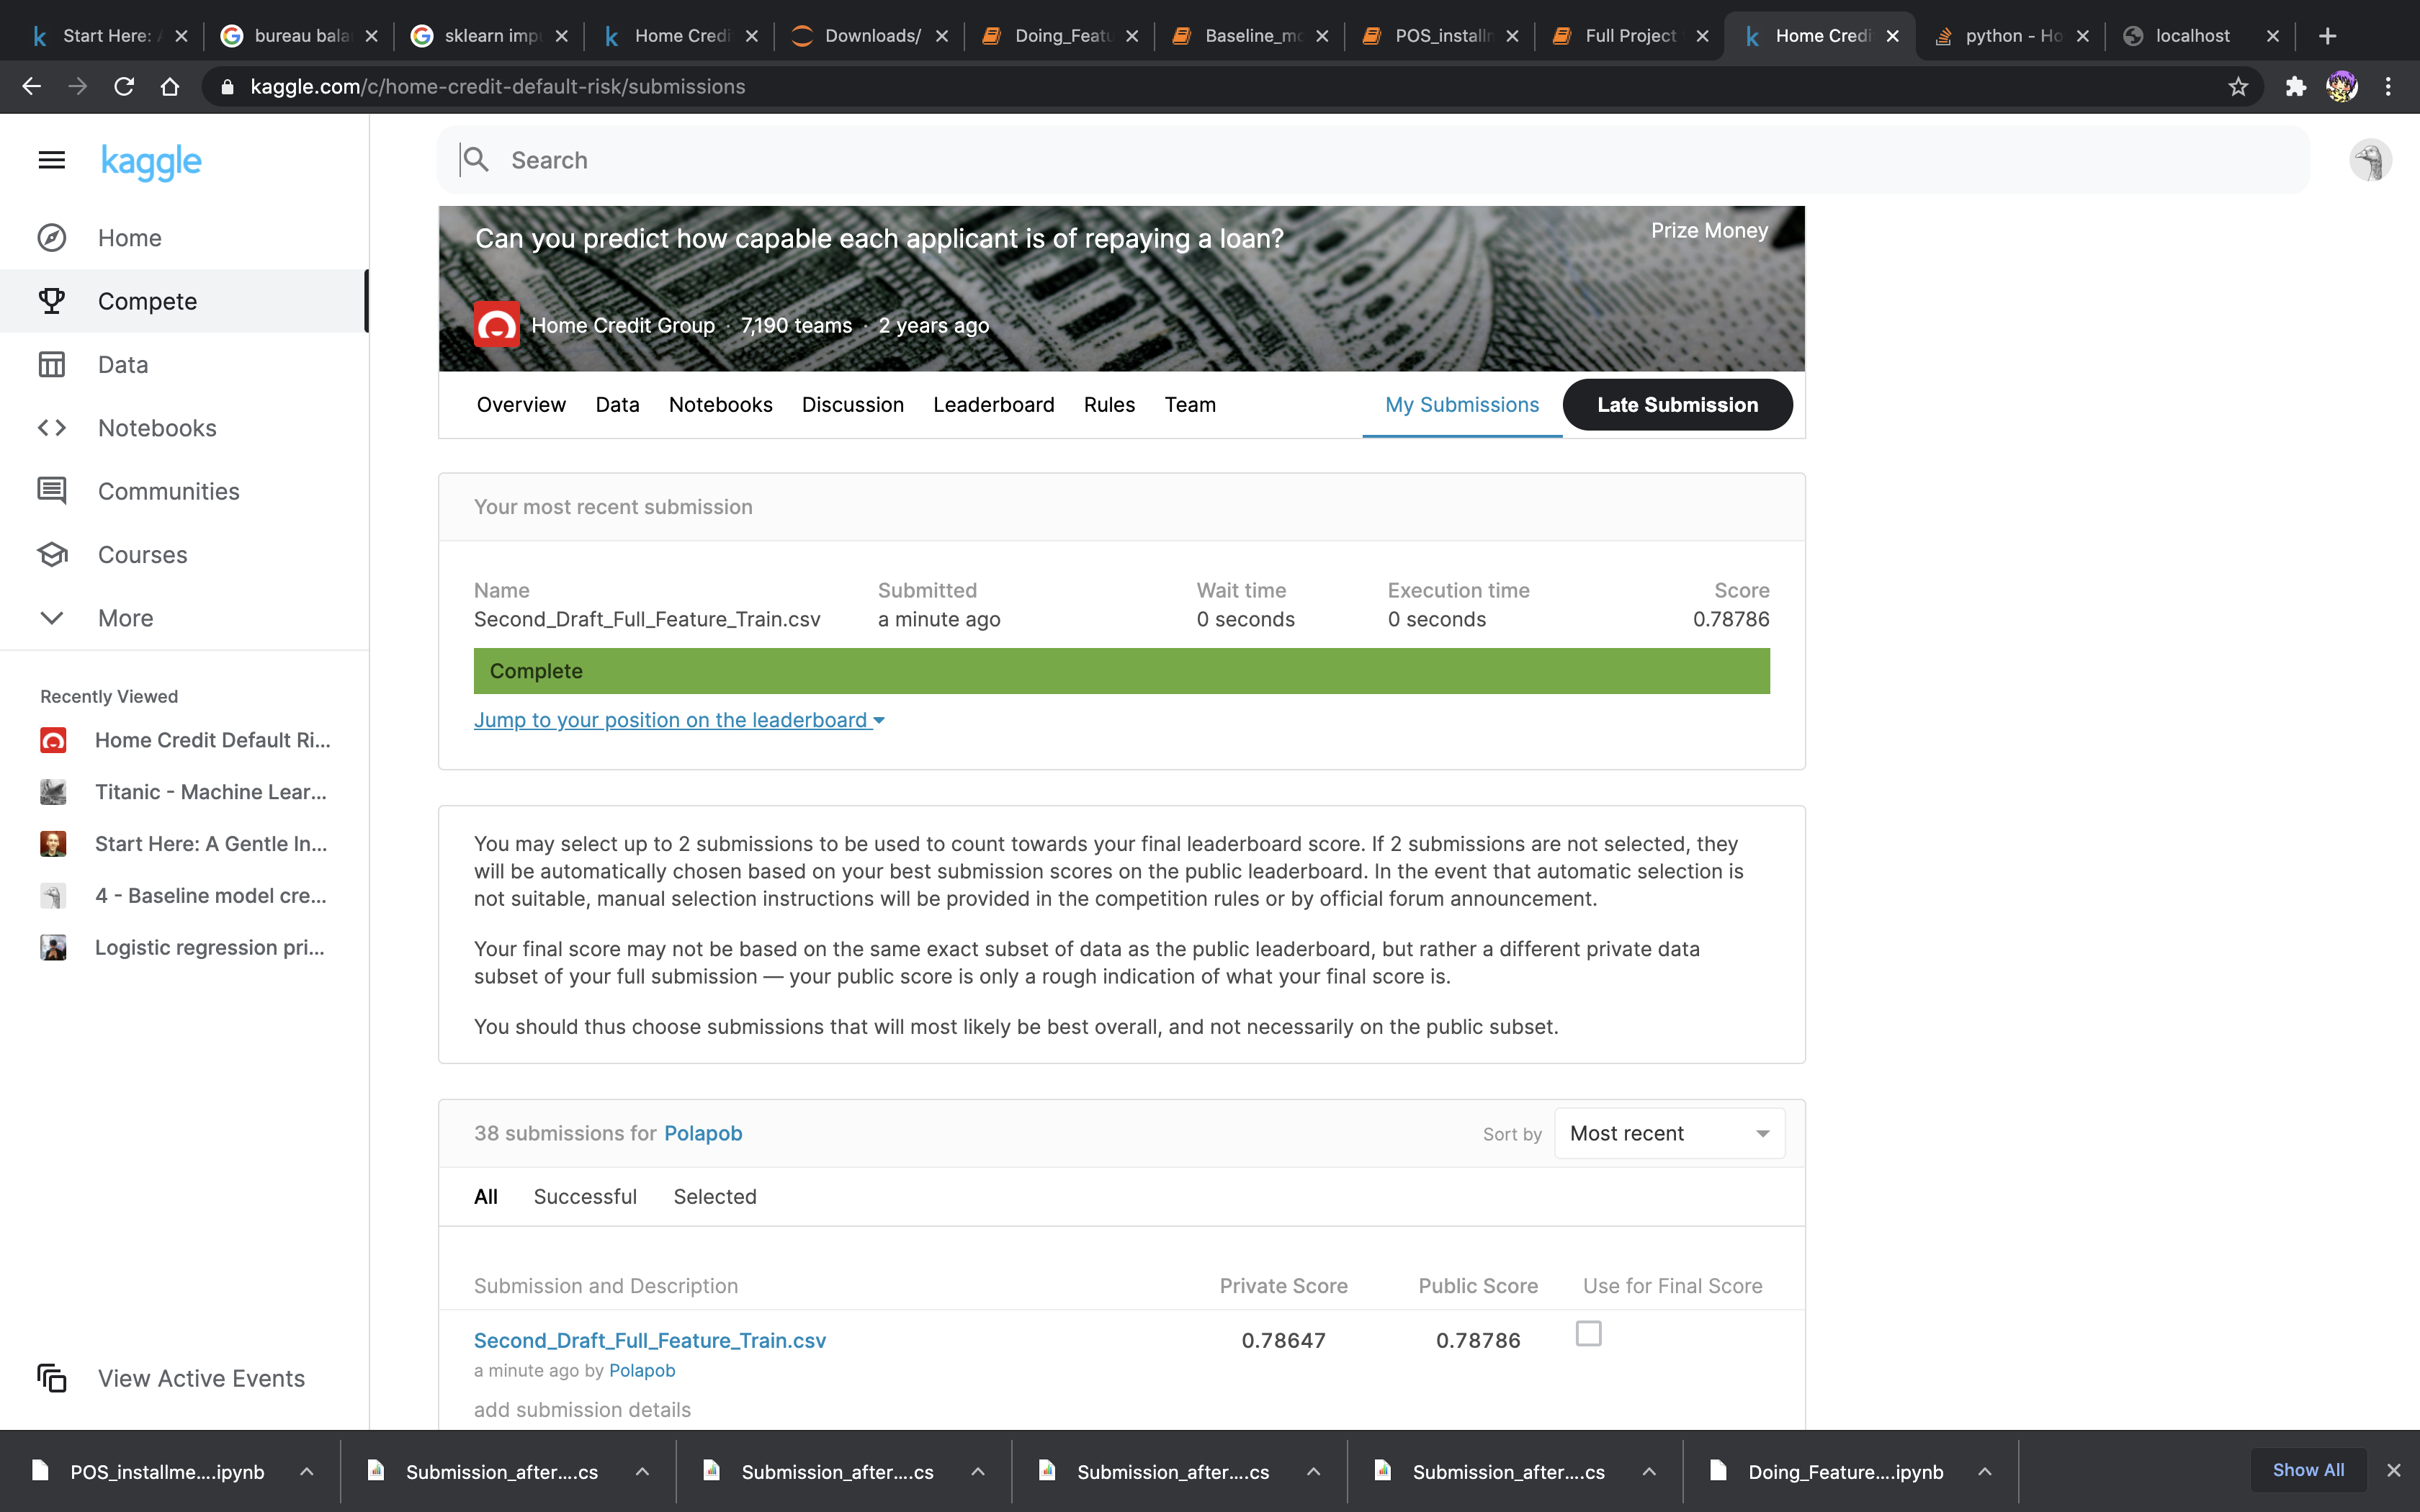

Second upgrade submission

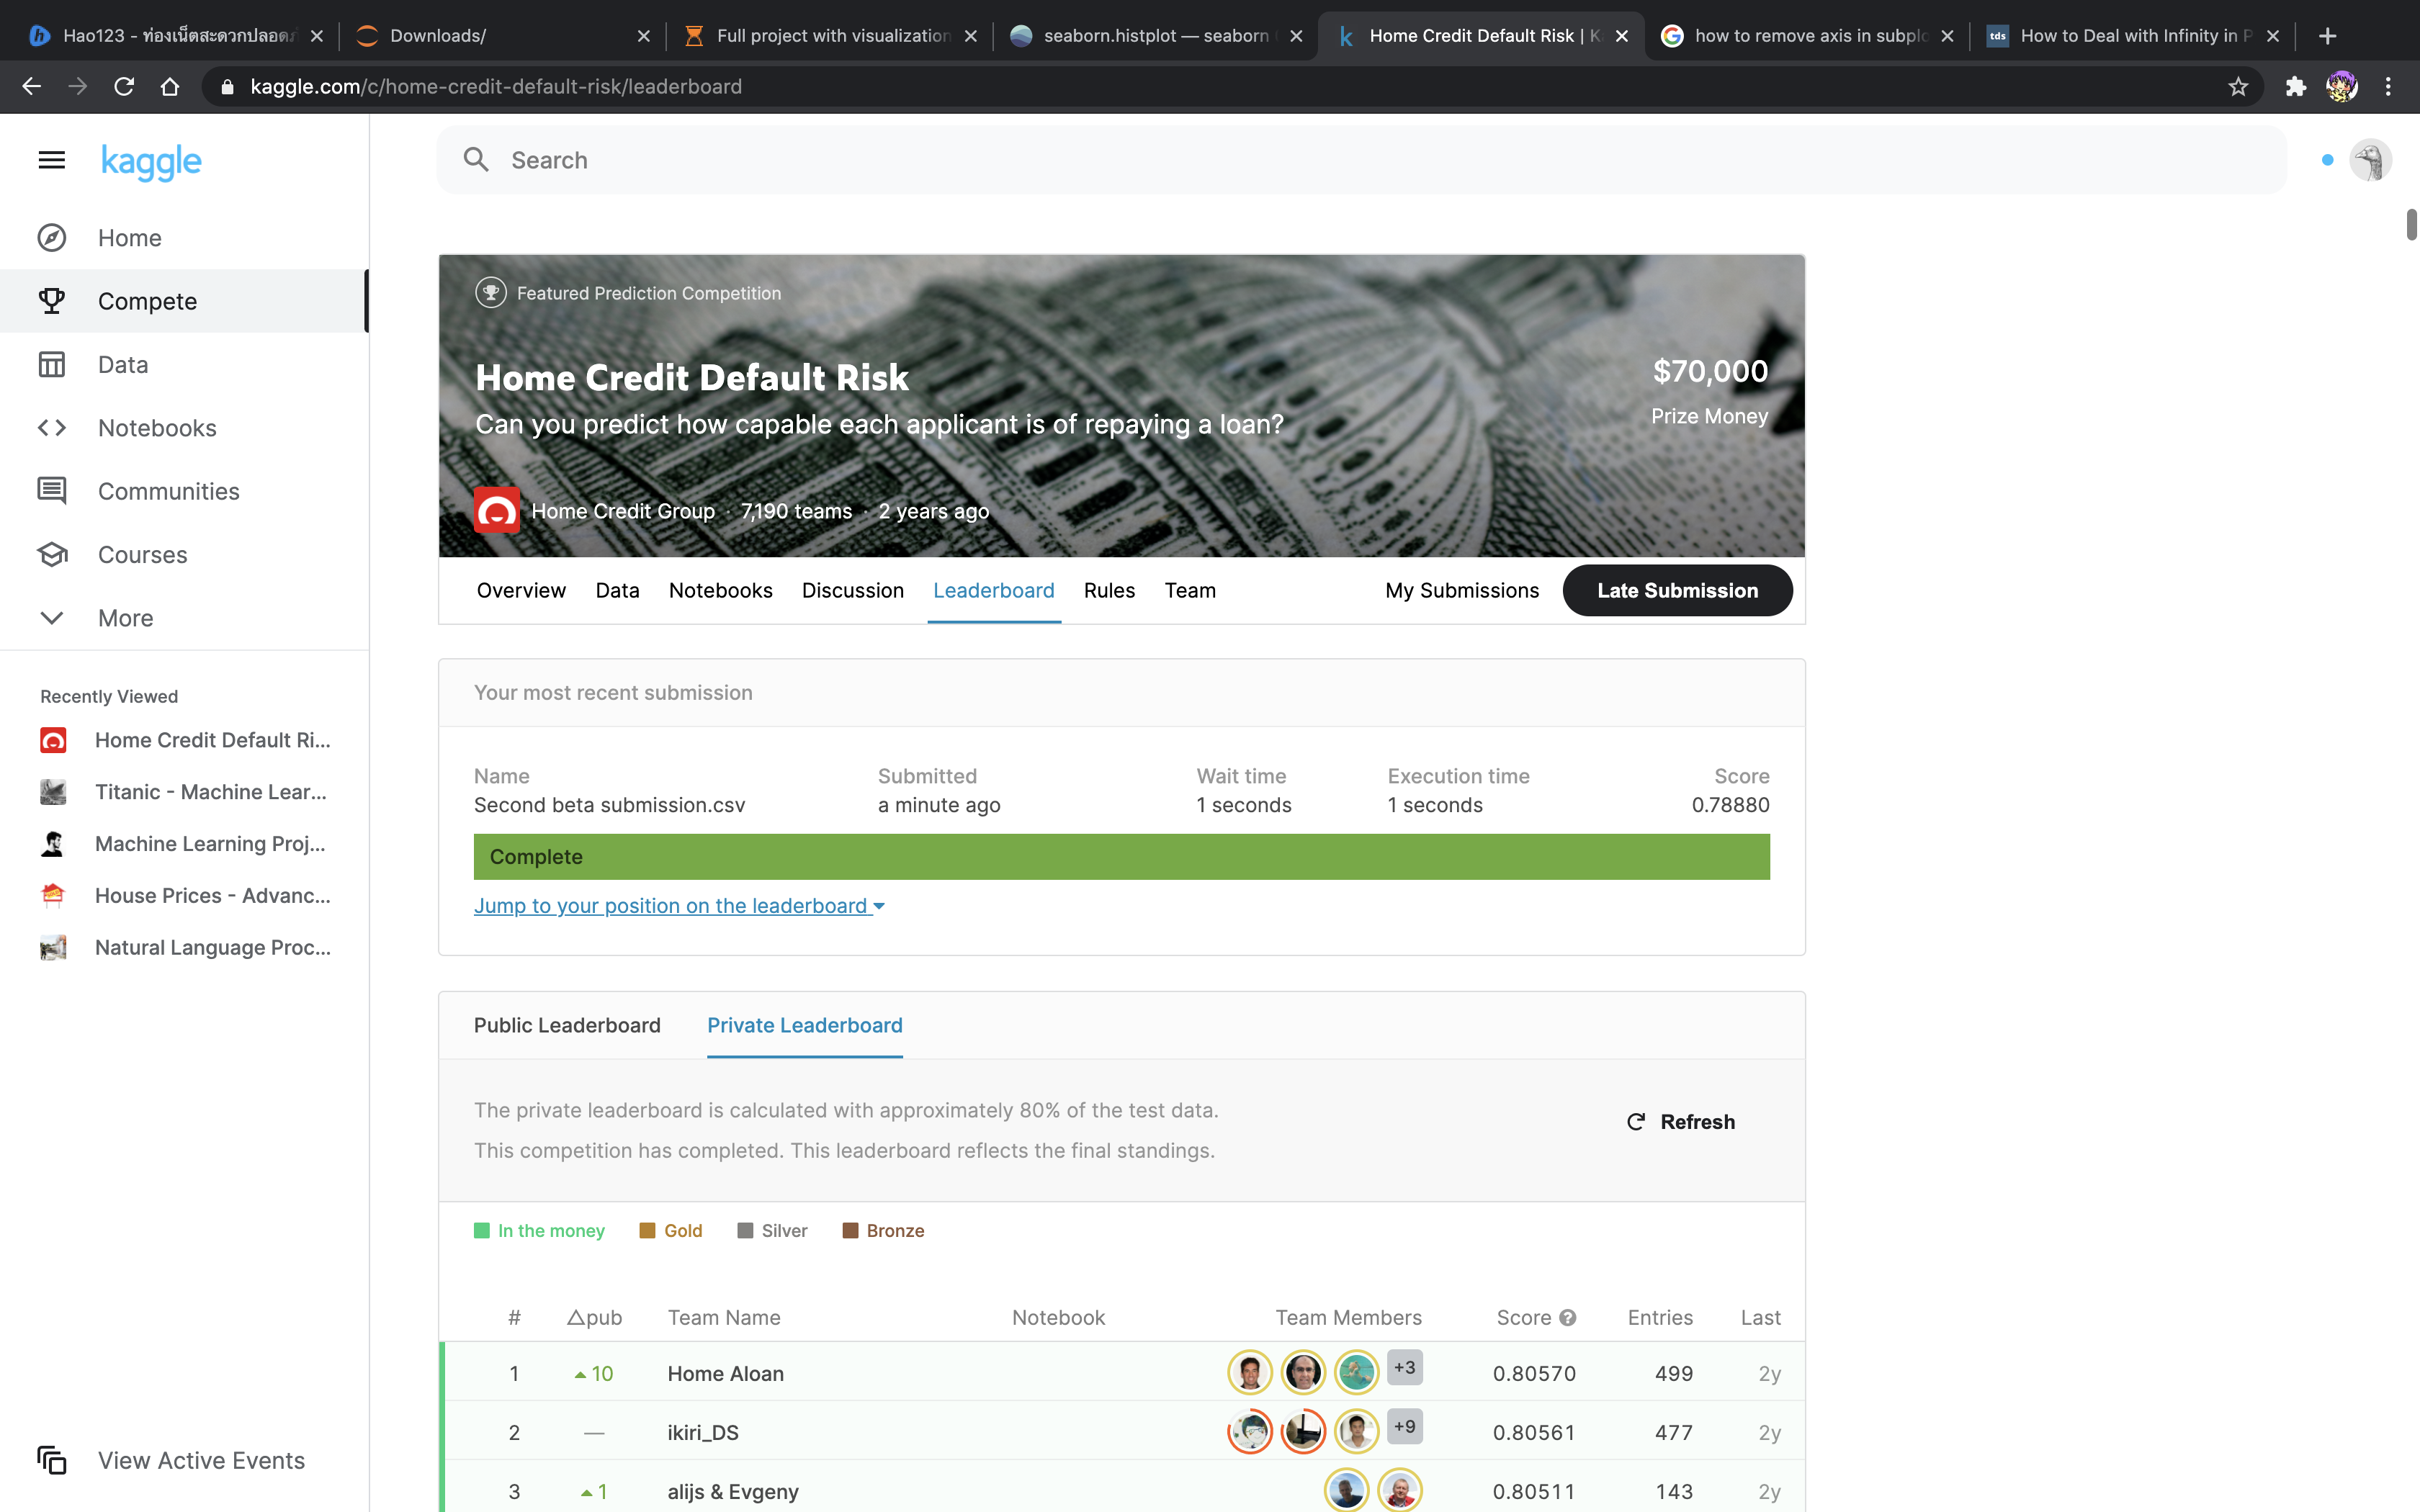

<h3>Check feature important

In [219]:
feature = feature.sort_values(by="importance",ascending=False)
feature 

feature  importance
1502                          Ratio_credit_with_annuity       268.2
10                                          AMT_ANNUITY       164.4
241              EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3       145.8
338                               LOAN_per_credit_ratio       126.6
239                                        EXT_SOURCE_1       115.2
...                                                 ...         ...
885   Previous_Application_CARD_BALANCE_CNT_DRAWINGS...         0.0
886   Previous_Application_CARD_BALANCE_CNT_DRAWINGS...         0.0
887   Previous_Application_CARD_BALANCE_CNT_DRAWINGS...         0.0
888   Previous_Application_CARD_BALANCE_CNT_DRAWINGS...         0.0
1581                                     terraced house         0.0

[1582 rows x 2 columns]

In [220]:
feature.reset_index(drop=True,inplace=True)

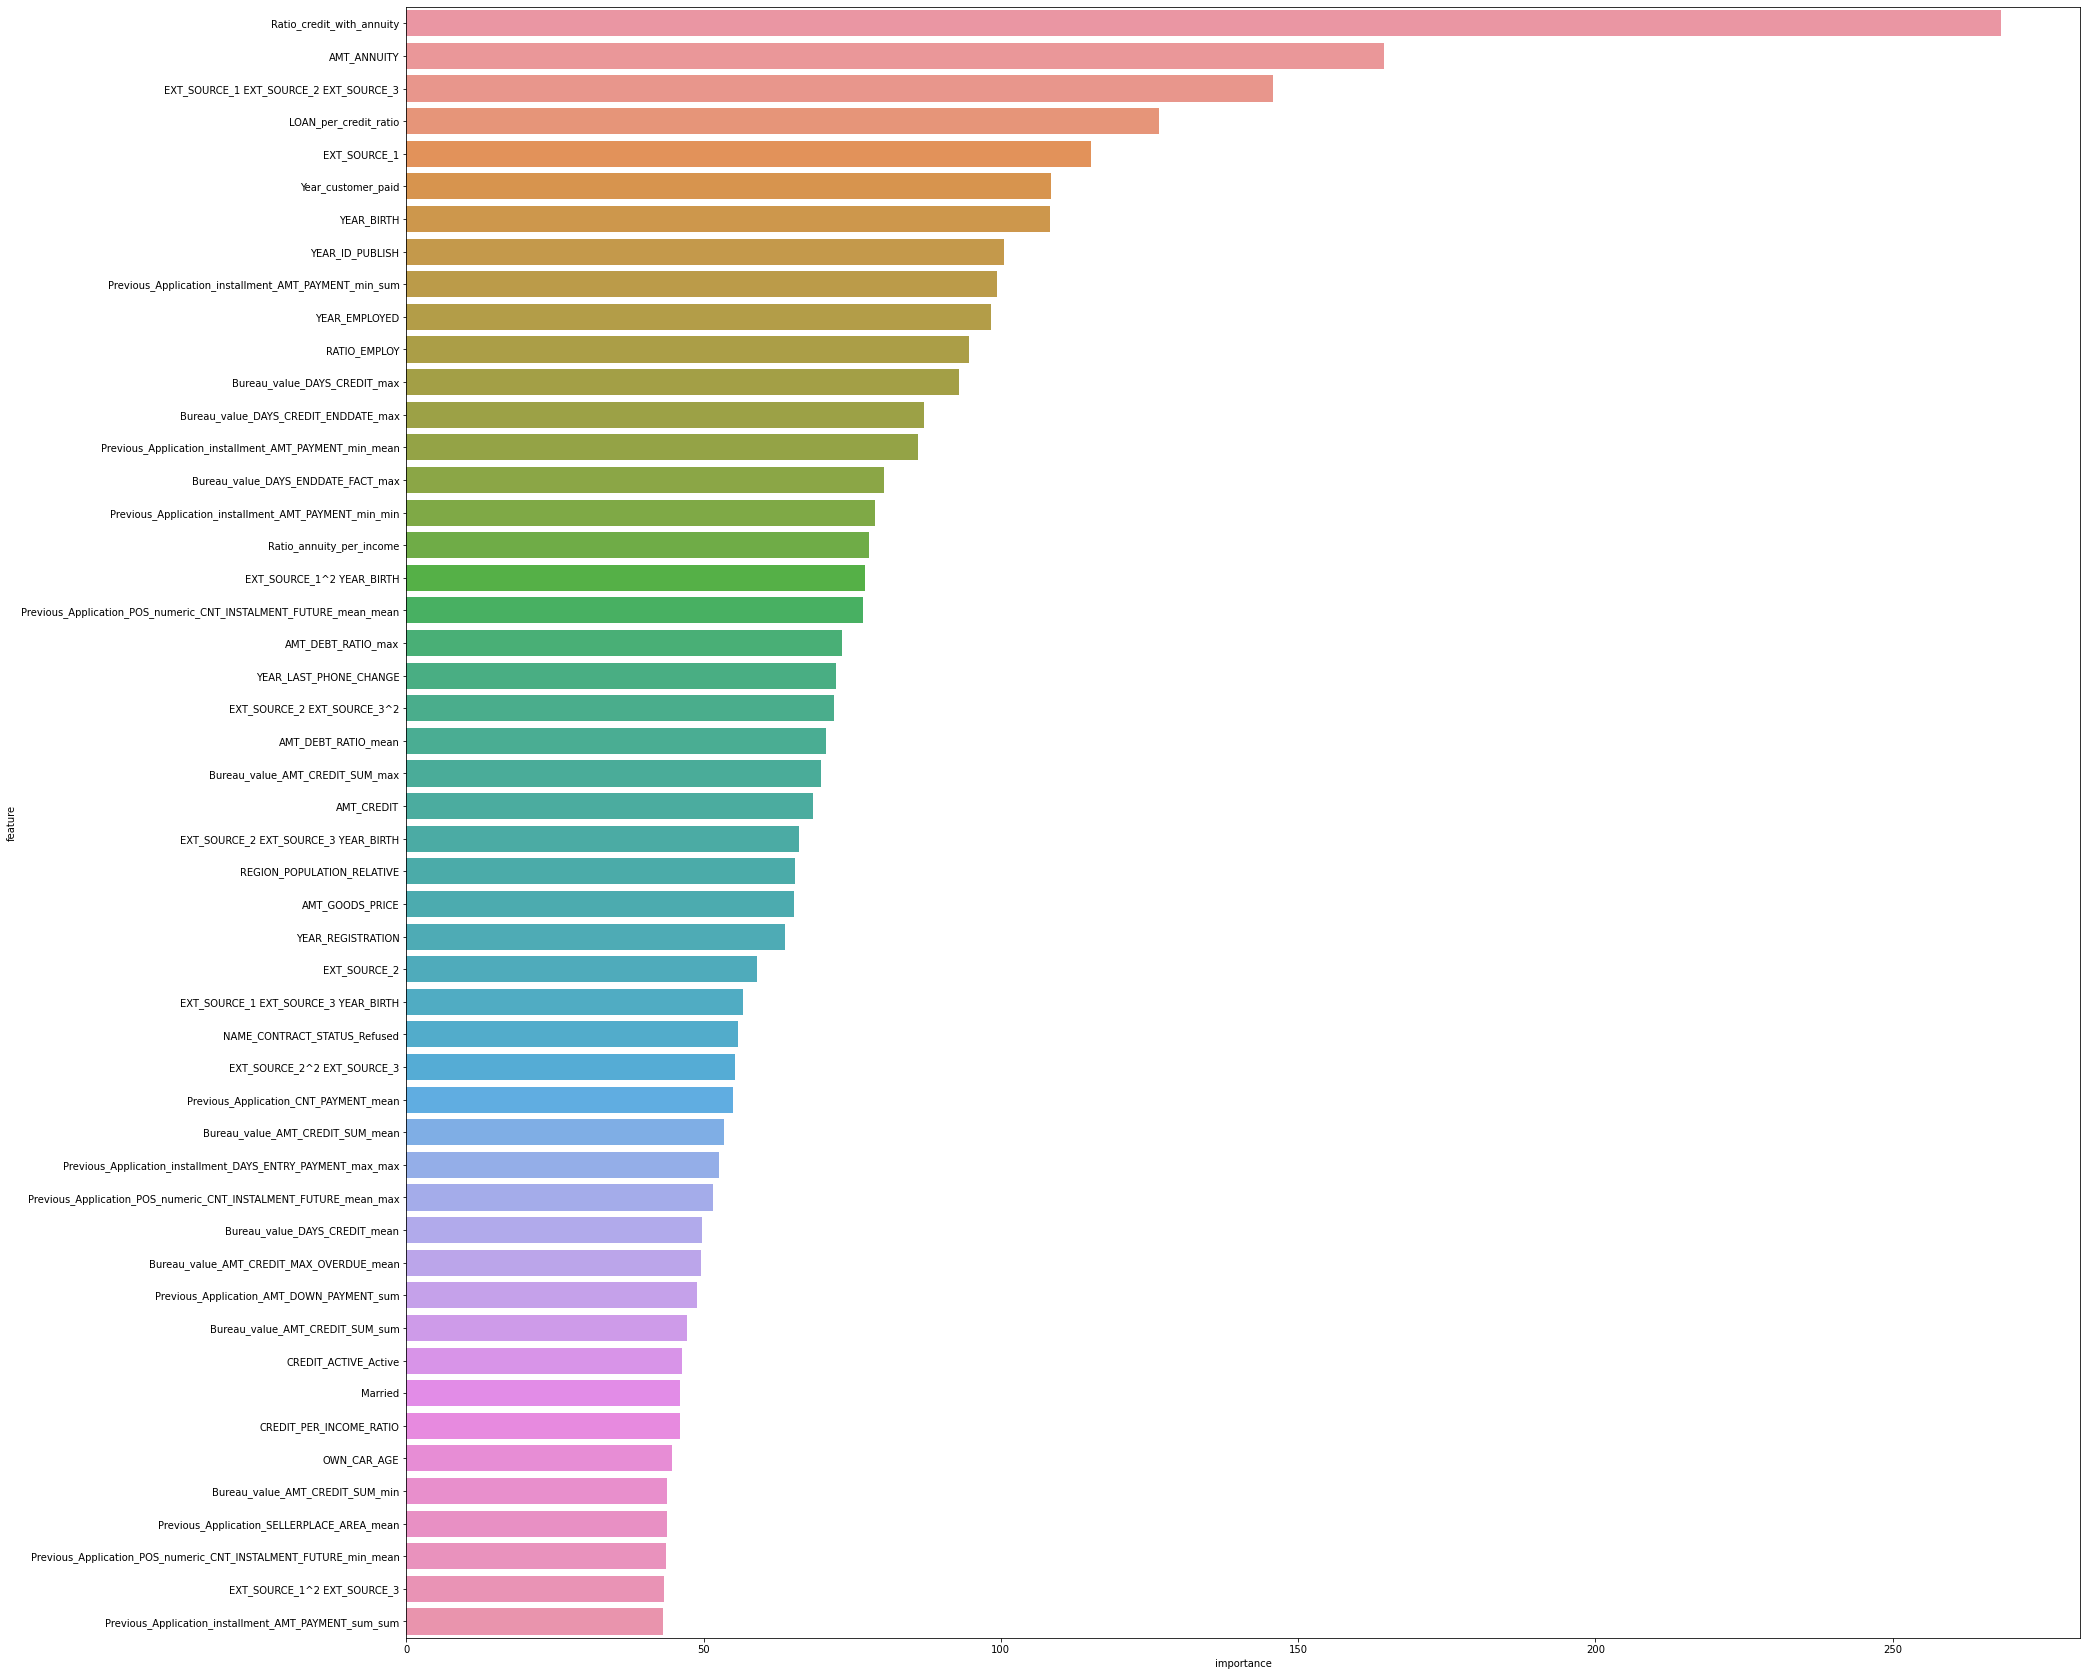

In [221]:
plt.figure(figsize=(30,30))
sns.barplot(data = feature.iloc[:50,:],y="feature",x="importance")
plt.show()